In [2]:
from orphics import maps, sehgal as osehgal
import healpy as hp
from pixell import utils, enmap, curvedsky, enplot, wcsutils, powspec, lensing, reproject
import os
import numpy as np
import pandas as pd
import mpl_scatter_density

import matplotlib.pyplot as plt
import lmdb
from cosmikyu import datasets, transforms, gan, model, stats, sehgal
from cosmikyu import nn as cnn
from cosmikyu import utils as cutils
from cosmikyu import config as cconfig
import torch
from orphics import maps as omaps, cosmology
from pitas import power, flipper_tools, config, modecoupling as mcm
import scipy
from minkfncts2d import MF2D
from multiprocessing import Pool
import gc
import symlens as s
import pytempura as cs
from scipy import spatial
import PiInTheSky.binnedEstimatorFullSky as binEstFullSky

import scipy.stats 
import math
import time


%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
input_dir = "/home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues"
compts = ["kappa", "ksz", "tsz", "ir", "rad"]
plot_dir = "/home/dwhan89/scratch/outbox/cosmikyu"
def plot_path(x):
    return os.path.join(plot_dir, x)

output_dir = "/home/dwhan89/workspace/cosmikyu/output"
def output_path(x):
    return os.path.join(output_dir, x)


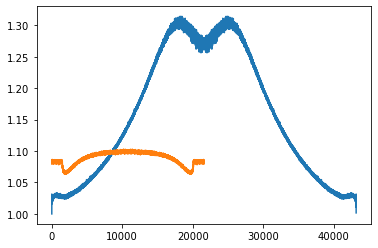

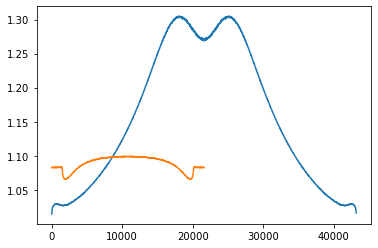

In [4]:
transf_x = np.load("/home/dwhan89/workspace/cosmikyu/data/sehgal/013121_interp_transf_x_raw.npy")
transf_y = np.load("/home/dwhan89/workspace/cosmikyu/data/sehgal/013121_interp_transf_y_raw.npy")

transf_x_smooth = scipy.ndimage.gaussian_filter1d(transf_x, 10)
transf_y_smooth = scipy.ndimage.gaussian_filter1d(transf_y, 10)

plt.plot(transf_x)
plt.plot(transf_y)
plt.show()

plt.plot(transf_x_smooth)
plt.plot(transf_y_smooth)
plt.show()

In [5]:
cuda = False
ngpu = 4
norm_info_file = "/home/dwhan89/workspace/cosmikyu/data/sehgal/281220_logz_normalization_info_validation.npz"
kappa_spec_file = "/home/dwhan89/scratch/data/sehgal_et_al_sims/theoryCls/clkk_sim.npy"
cmb_spec_file = "/home/dwhan89/scratch/data/sehgal_et_al_sims/theoryCls/bode_almost_wmap5_lmax_1e4_scalCls.dat"

xgrid_file = "/home/dwhan89/workspace/cosmikyu/data/sehgal/0.5_fullsky_gridv2_21600x43200.npy"
weight_file = "/home/dwhan89/workspace/cosmikyu/data/sehgal/0.5_fullsky_weightv3_21600x43200.npy"

experiment_id = "6dd3053687de464aabc4a2bb441e60cf"
save_point = 6
model_dir = "/home/dwhan89/workspace/cosmikyu/output/sehgal_pixganwgp_281220/{}/model".format(experiment_id)
pixgan_state_file = os.path.join(model_dir, "generator{}.pt".format("_{}".format(save_point)))

experiment_id = "6c187e10f7ad45c8b6e6ebb7c0b15d31"
save_point = 13
model_dir = "/home/dwhan89/workspace/cosmikyu/output/sehgal_forse_281220/{}/model".format(experiment_id)
tuner_state_file = os.path.join(model_dir, "generator{}.pt".format("_{}".format(save_point)))

#transfer_file = os.path.join(input_dir,"281220_sehgal_network_transfer.npy")
#transfer_2dspec_file = '/home/dwhan89/workspace/cosmikyu/output/mlsimsv0.11_transf_2dspec_final.npz'
#transfer_1dspec_file = '/home/dwhan89/workspace/cosmikyu/cosmikyu/../output/mlsimsv0.1_transf_1dspec.npz'
transfer_2dspec_file = '/home/dwhan89/workspace/cosmikyu/output/033021_mlsims_transf_2dspec_final.npz'
transfer_1dspec_file = '/home/dwhan89/workspace/cosmikyu//output/033021_mlsims_transf_1dspec_final.npz'

ir_spectra_index_file = "/home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/cib_spectra_indexv3.npz"
radio_spectra_index_file = "/home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/radio_spectra_indexv2.npz"

output_dir = cconfig.default_output_dir
output_dir = os.path.join(output_dir, "final")
sim_dir = os.path.join(output_dir, "sim")

os.makedirs(sim_dir, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)


SN = sehgal.SehgalNetworkFullSky(cuda, ngpu, 512, norm_info_file, 
                          pixgan_state_file, tuner_state_file, kappa_spec_file, cmb_spec_file, transfer_1dspec_file, transfer_2dspec_file, ir_spectra_index_file,
                                 radio_spectra_index_file,20, 80, xgrid_file, 
                                 weight_file, output_dir=output_dir)


[WARNING] You have a CUDA device. You probably want to run with CUDA enabled
Loading /home/dwhan89/workspace/cosmikyu/output/sehgal_pixganwgp_281220/6dd3053687de464aabc4a2bb441e60cf/model/generator_6.pt
Loading /home/dwhan89/workspace/cosmikyu/output/sehgal_forse_281220/6c187e10f7ad45c8b6e6ebb7c0b15d31/model/generator_13.pt


In [ ]:
overwrite = False

for sim_idx in range(400,500):
    stime = time.time()
    fname = SN.get_output_file_name("rad_pts", sim_idx, 148)#SN.freqs[-1])
    
    if not os.path.exists(fname) or overwrite:
        fgmaps_148 = SN.get_foreground(sim_idx, freq=148, overwrite=True)
        #spec_indxes = {}
        #spec_indxes["rad_pts"]= SN._get_spectral_index(seed=sim_idx, compt_idx="rad_pts")
        #spec_indxes["ir_pts"]= SN._get_spectral_index(seed=sim_idx, compt_idx="ir_pts")
        print(sim_idx, "init", time.time()-stime)
        for freq in [148]:#SN.freqs:
            if freq == 148: continue
            SN.get_foreground(sim_idx, freq=freq, fgmaps_148=fgmaps_148)
            print(sim_idx, freq, time.time()-stime)
        del fgmaps_148#, spec_indxes
print("done")

In [ ]:
overwrite = False

gc.collect()

sim_idx  = 0
output_file = output_path(f"m10r_{sim_idx:05}_lcmbv2.fits")
if not os.path.exists(output_file) or overwrite:
    cmb_spec_file = "/home/dwhan89/scratch/data/sehgal_et_al_sims/theoryCls/bode_almost_wmap5_lmax_1e4_scalCls.dat"
    S10R = sehgal.Sehgal10ReprojectedFromCat(input_dir, SN.shape[-2:], SN.wcs)
    compts = ["kappa", "ksz", "tsz", "ir", "rad"]
    ps_unlen = powspec.read_camb_scalar(cmb_spec_file)
    lmax = 10000
    
    print(output_file)
    kappa = S10R.get_maps(0,0, load_processed=False, compts=["kappa"])[0][0]
    ualm = curvedsky.rand_alm(ps_unlen[0], lmax=lmax, seed=sehgal.seed_tracker.get_cmb_seed(sim_idx))

    l = np.arange(lmax+1)
    l_fact = 1/((l*(l+1))/2)
    l_fact[0] = 0
    kalm = curvedsky.map2alm(kappa, lmax=lmax); del kappa
    kalm = hp.almxfl(kalm, l_fact)
    tshape, twcs = enmap.fullsky_geometry(res=1*utils.arcmin)
    print("start lensing")
    slmaps = lensing.lens_map_curved((3,)+tshape, twcs, kalm, ualm)[0]
    print("finish lensing")
    slalms = curvedsky.map2alm(slmaps, lmax=lmax, spin=0)
    slmaps = curvedsky.alm2map(slalms, enmap.zeros((3,)+SN.shape, SN.wcs), spin=0)
    enmap.write_map(output_file, slmaps.astype(np.float32))
    del kalm, ualm, slalms, slmaps
gc.collect() 
print("done")

In [5]:
overwrite = False
for sim_idx in range(400,500):
    gc.collect()
    output_file = SN.get_output_file_name("lensed_cmb", sim_idx, polidx='U')
    if not os.path.exists(output_file) or overwrite:
        SN.get_lensed_cmb(sim_idx)
gc.collect() 
print("done")

NameError: name 'SN' is not defined

In [9]:
target = SN.get_lensed_cmb(2)
for i, polidx in enumerate(['T','Q','U']):
    output_file = SN.get_output_file_name("lensed_cmb", 2, polidx=polidx)
    output_file = output_file.replace("final", "final_hp")
    hpmap = reproject.healpix_from_enmap(target[i], 10000, 8192)
    hp.write_map(output_file, hpmap)
    
    

trying to load saved lensed cmb. sim idx: 2
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


/home/dwhan89/.miniconda3/lib/python3.7/site-packages/healpy/fitsfunc.py:187: FutureWarning: The default dtype of write_map() will change in a future version: explicitly set the dtype if it is important to you
  category=FutureWarning)


Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


/home/dwhan89/.miniconda3/lib/python3.7/site-packages/healpy/fitsfunc.py:187: FutureWarning: The default dtype of write_map() will change in a future version: explicitly set the dtype if it is important to you
  category=FutureWarning)


Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


/home/dwhan89/.miniconda3/lib/python3.7/site-packages/healpy/fitsfunc.py:187: FutureWarning: The default dtype of write_map() will change in a future version: explicitly set the dtype if it is important to you
  category=FutureWarning)


In [17]:
target = SN.get_foreground(2)
for i, fgidx in enumerate(["kappa", "ksz", "tsz", "ir_pts", "rad_pts"]):
    output_file = SN.get_output_file_name(fgidx, 2, freq=148)
    output_file = output_file.replace("final", "final_hp")
    print(output_file)
    hpmap = reproject.healpix_from_enmap(target[i], 10000, 8192)
    hp.write_map(output_file, hpmap)
    

trying to load saved foregrounds. sim idx: 2, freq: 148GHz
/home/dwhan89/workspace/cosmikyu/cosmikyu/../output/final_hp/00002/kappa_00002.fits
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


/home/dwhan89/.miniconda3/lib/python3.7/site-packages/healpy/fitsfunc.py:187: FutureWarning: The default dtype of write_map() will change in a future version: explicitly set the dtype if it is important to you
  category=FutureWarning)


/home/dwhan89/workspace/cosmikyu/cosmikyu/../output/final_hp/00002/ksz_00002.fits
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


/home/dwhan89/.miniconda3/lib/python3.7/site-packages/healpy/fitsfunc.py:187: FutureWarning: The default dtype of write_map() will change in a future version: explicitly set the dtype if it is important to you
  category=FutureWarning)


/home/dwhan89/workspace/cosmikyu/cosmikyu/../output/final_hp/00002/tsz_148ghz_00002.fits
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


/home/dwhan89/.miniconda3/lib/python3.7/site-packages/healpy/fitsfunc.py:187: FutureWarning: The default dtype of write_map() will change in a future version: explicitly set the dtype if it is important to you
  category=FutureWarning)


/home/dwhan89/workspace/cosmikyu/cosmikyu/../output/final_hp/00002/ir_pts_148ghz_00002.fits
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


/home/dwhan89/.miniconda3/lib/python3.7/site-packages/healpy/fitsfunc.py:187: FutureWarning: The default dtype of write_map() will change in a future version: explicitly set the dtype if it is important to you
  category=FutureWarning)


/home/dwhan89/workspace/cosmikyu/cosmikyu/../output/final_hp/00002/rad_pts_148ghz_00002.fits
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


/home/dwhan89/.miniconda3/lib/python3.7/site-packages/healpy/fitsfunc.py:187: FutureWarning: The default dtype of write_map() will change in a future version: explicitly set the dtype if it is important to you
  category=FutureWarning)


In [8]:
STAT_TEST_FC = stats.STATS("040821_sehgal_fullsky_specs_finer_7mjy", output_dir=output_dir, overwrite=False)


key = "dls_148_"+"x".join(["ksz","rad"])
if STAT_TEST_FC.has_data(key, 0): 
    pass
else:
    lmax = 10000
    S10R = sehgal.Sehgal10ReprojectedFromCat(input_dir, SN.shape[-2:], SN.wcs)
    compts = ["kappa", "ksz", "tsz", "ir", "rad"]
    sample = S10R.get_maps(0,0,ret_alm=False,flux_cut=7, load_processed=False)
    l = np.arange(lmax+1)
    bin_edges = np.linspace(0,lmax, 50)
    binner = mcm.PITAS_BINNER(bin_edges, lmax=lmax)
    l_fact = l*(l+1)/(2*np.pi)
    freq = 148
    alms = {}
    for j, compt_idx in enumerate(compts):
        emap = sample[j]
        alms[compt_idx] = curvedsky.map2alm(emap, lmax=lmax)
    del sample
    for j, key1 in enumerate(compts):
        for k, key2 in enumerate(compts):
            key1 = key1.split("_")[0]
            key2 = key2.split("_")[0]
            key = [key1, key2]
            key.sort()
            key = f"dls_{freq:03d}_"+"x".join(key)
            if STAT_TEST_FC.has_data(key, 0): continue

            cl = hp.alm2cl(alms[key1], alms[key2])

            dl = l_fact*cl
            lbin, dlbin = binner.bin(l, dl)
            #dlbin = np.dot(PITAS.mcm_dltt_inv, dlbin)#*transfer
            STAT_TEST_FC.add_data("lbin", 0, lbin)
            STAT_TEST_FC.add_data(key, 0, dlbin)
            
    if not STAT_TEST_FC.has_data('dlbb', i): 
        sim_idx = 0
        sample = np.float64(enmap.read_fits(output_path(f"m10r_{sim_idx:05}_lcmbv2.fits")))
        alms = curvedsky.map2alm(sample, lmax=lmax)
        for i, polidx in enumerate(['tt','ee','bb']):
            cl = hp.alm2cl(alms[i]) 
            dl = l_fact*cl
            lbin, dlbin = binner.bin(l, dl)
            STAT_TEST_FC.add_data("lbin", 0, lbin)
            STAT_TEST_FC.add_data(f"dl{polidx}", 0, dlbin)
        del sample, alms
    #dlbin = np.dot(PITAS.mcm_dltt_inv, dlbin)#*transfer

            
STAT_TEST_FC.get_stats()
pass

[STATS] output_dir is /home/dwhan89/workspace/cosmikyu/cosmikyu/../output/final
[STATS] loaded /home/dwhan89/workspace/cosmikyu/cosmikyu/../output/final/stats_040821_sehgal_fullsky_specs_finer_7mjy.npz
[STATS] collecting data
[STATS] saving /home/dwhan89/workspace/cosmikyu/cosmikyu/../output/final/stats_040821_sehgal_fullsky_specs_finer_7mjy.npz from root 0
[STATS] loaded /home/dwhan89/workspace/cosmikyu/cosmikyu/../output/final/stats_040821_sehgal_fullsky_specs_finer_7mjy.npz
calculating stats


/home/dwhan89/workspace/cosmikyu/cosmikyu/stats.py:118: RuntimeWarning: Degrees of freedom <= 0 for slice
  cov = np.cov(data.transpose(), ddof=ddof)
/home/dwhan89/.miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/dwhan89/.miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/dwhan89/.miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/home/dwhan89/.miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/dwhan89/.miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:224: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=F

In [9]:

overwrite = False
STAT_GEN_FC = stats.STATS("040121_sehgal_gen_spec_nn_7mjy_test", output_dir=output_dir, overwrite=overwrite)
for i in range(1,2):
    sim_idx = i
    print(i)    
    lmax = 10000
    l = np.arange(lmax+1)
    l_fact = l*(l+1)/(2*np.pi)
    bin_edges = np.linspace(0,10000, 50)
    binner = mcm.PITAS_BINNER(bin_edges, lmax=10000)
    for freq in [148]:#SN.freqs:
        key = f"dls_{freq:03d}_"+"x".join(["ksz","rad"])
        if STAT_GEN_FC.has_data(key, i): continue

        
        
        sample = SN.get_foreground(sim_idx, freq=freq)
        compts = ["kappa", "ksz", "tsz", "ir", "rad"]

        alms = {}
        for j, compt_idx in enumerate(compts):
            #if j < 3: continue
            emap = sample[j]
            alms[compt_idx] = curvedsky.map2alm(emap.astype(np.float64), lmax=lmax)
        del sample, emap
        for j, key1 in enumerate(compts):
            for k, key2 in enumerate(compts):
                key1 = key1.split("_")[0]
                key2 = key2.split("_")[0]
                key = [key1, key2]
                key.sort()
                key = f"dls_{freq:03d}_"+"x".join(key)
                if STAT_GEN_FC.has_data(key, i): continue
                print(i, key)

                cl = hp.alm2cl(alms[key1], alms[key2])
                dl = l_fact*cl
                lbin, dlbin = binner.bin(l, dl)
                #dlbin = np.dot(PITAS.mcm_dltt_inv, dlbin)#*transfer
                STAT_GEN_FC.add_data("lbin", 0, lbin)
                STAT_GEN_FC.add_data(key, i, dlbin)


    if  STAT_GEN_FC.has_data('dlbb', i) or True: continue
    sample = SN.get_lensed_cmb(sim_idx).astype(np.float64)
    alms = curvedsky.map2alm(sample, lmax=lmax)
    for i, polidx in enumerate(['tt','ee','bb']):
        cl = hp.alm2cl(alms[i]) 
        dl = l_fact*cl
        lbin, dlbin = binner.bin(l, dl)
        STAT_GEN_FC.add_data("lbin", sim_idx, lbin)
        STAT_GEN_FC.add_data(f"dl{polidx}", sim_idx, dlbin)
    del sample, alms
    
STAT_GEN_FC.get_stats()
pass

[STATS] output_dir is /home/dwhan89/workspace/cosmikyu/cosmikyu/../output/final
[STATS] loaded /home/dwhan89/workspace/cosmikyu/cosmikyu/../output/final/stats_040121_sehgal_gen_spec_nn_7mjy_test.npz
1
trying to load saved foregrounds. sim idx: 1, freq: 148GHz
1 dls_148_kappaxkappa
1 dls_148_kappaxksz
1 dls_148_kappaxtsz
1 dls_148_irxkappa
1 dls_148_kappaxrad
1 dls_148_kszxksz
1 dls_148_kszxtsz
1 dls_148_irxksz
1 dls_148_kszxrad
1 dls_148_tszxtsz
1 dls_148_irxtsz
1 dls_148_radxtsz
1 dls_148_irxir
1 dls_148_irxrad
1 dls_148_radxrad
[STATS] collecting data
[STATS] saving /home/dwhan89/workspace/cosmikyu/cosmikyu/../output/final/stats_040121_sehgal_gen_spec_nn_7mjy_test.npz from root 0
[STATS] loaded /home/dwhan89/workspace/cosmikyu/cosmikyu/../output/final/stats_040121_sehgal_gen_spec_nn_7mjy_test.npz
calculating stats


/home/dwhan89/.miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/dwhan89/workspace/cosmikyu/cosmikyu/stats.py:118: RuntimeWarning: Degrees of freedom <= 0 for slice
  cov = np.cov(data.transpose(), ddof=ddof)
/home/dwhan89/.miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/dwhan89/.miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/dwhan89/.miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/home/dwhan89/.miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/dwhan89/.minico

<Figure size 432x288 with 0 Axes>

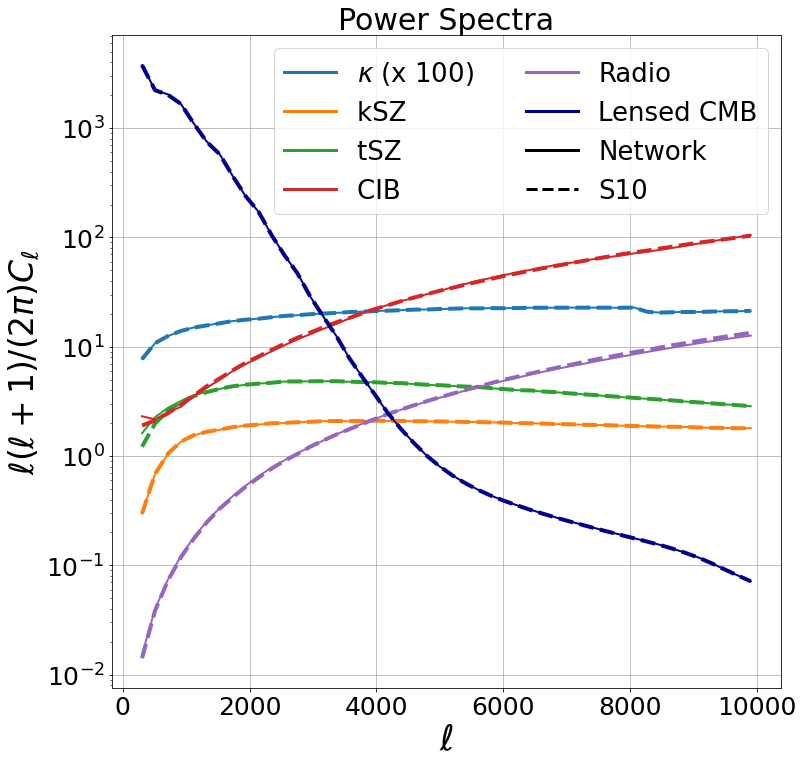

In [31]:
##ps

def key2label(key):
    storage = {"kappa":r"$  \kappa$ (x 100)",
               "ksz":"kSZ ",
               "tsz":"tSZ ",
               "ir":"CIB ",
               "rad":"Radio",
              }
    return storage[key]



flux_cut = True
bin_edges = np.linspace(0,10000, 50)
binner = mcm.PITAS_BINNER(bin_edges, lmax=10000)
plt.clf()
fig = plt.figure(figsize=(12,12))
ax = fig.gca()
lbin = binner.bin_center.copy()
loc = np.where(lbin>200)
for key1 in compts[:5]:
    key2 = key1
    key = [key1, key2]
    key.sort()
    freq = 148
    key = f"dls_{freq:03d}_"+"x".join(key)
    skey = key
    multi_fact = 1e4 if key1 == "kappa" else 1
 
    color = next(ax._get_lines.prop_cycler)['color']
   
    dlbin = STAT_TEST_FC.stats[key]["mean"]*multi_fact
    plt.plot(lbin[loc], dlbin[loc], alpha=1, lw=4, marker="",markersize=8, color=color, ls="--")
   
    #dlbin =  STAT_GEN_FC.stats[key]["mean"]*multi_fact
    dlbin =  STAT_GEN_FC.storage[key][10]*multi_fact
    #print(STAT_GEN_FC.stats[key]["mean"]/STAT_TEST_FC.stats[key]["mean"])
    plt.plot(lbin[loc], dlbin[loc], alpha=1, lw=2, marker="",markersize=12, color=color, ls="-")
    
    '''
    dl = fg_specs[key]*multi_fact
    l = np.arange(len(dl))
    plt.plot(l,dl, ls=":", color=color)
    '''
    plt.plot([],[], lw=3, label=key2label(key1), color=color)
#color = "darkblue" #next(ax._get_lines.prop_cycler)['color']
#color = next(ax._get_lines.prop_cycler)['color']

for i, polidx in enumerate(['tt']):
    color = ['darkblue','b','g'][i]
    dlbin = STAT_TEST_FC.stats[f"dl{polidx}"]['mean'].copy()
    plt.plot(lbin[loc], dlbin[loc], alpha=1, lw=4, marker="",markersize=8, color=color, ls="--")
    dlbin = STAT_GEN_FC.stats[f"dl{polidx}"]['mean'].copy()
    plt.plot(lbin[loc], dlbin[loc], alpha=1, lw=2, marker="",markersize=12, color=color, ls="-")

plt.plot([],[], color=color, lw=3, label="Lensed CMB")


plt.title("Power Spectra", fontsize=30)
plt.plot([],[], lw=3, marker="", ls="-", label="Network",  color="k")    
plt.plot([],[], lw=3, marker="", label="S10", color="k", ls="--")
ax.set_ylabel(r"$\ell(\ell+1)/(2\pi )C_\ell$", fontsize=33)
ax.set_xlabel(r"$\ell$", fontsize=35)
plt.legend(fontsize=26, ncol=2)



ax.tick_params(axis='both', which='major', labelsize=25)
ax.tick_params(axis='both', which='minor', labelsize=25)
#ax.axvline(x=200, ls=":", color="k")
ax.set_yscale("log")
ax.grid()
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig(plot_path("030921_spec.pdf"), bbox_inches='tight')
plt.show()

<Figure size 432x288 with 0 Axes>

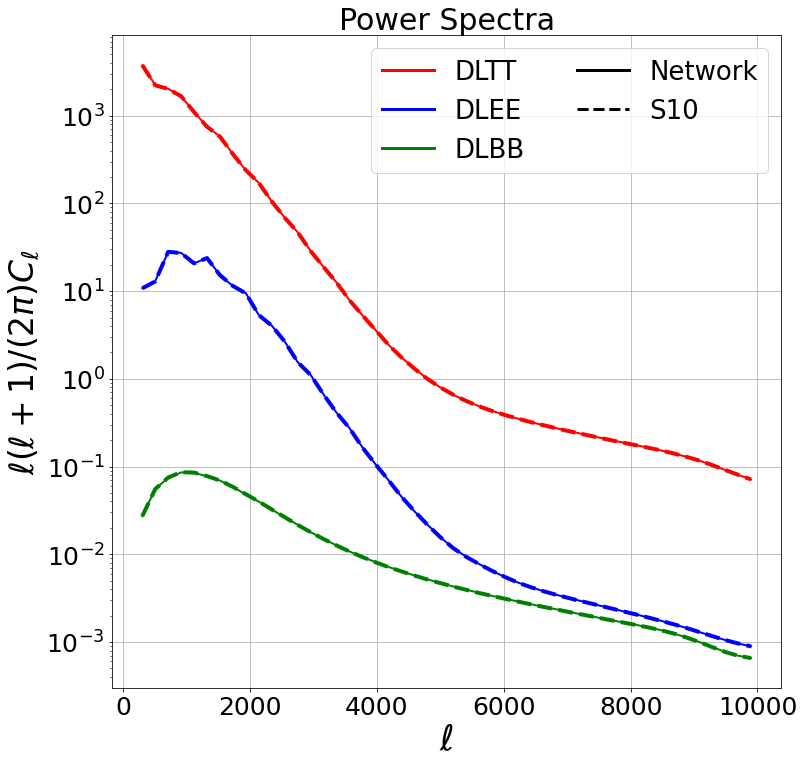

In [22]:
##poltest

flux_cut = True
bin_edges = np.linspace(0,10000, 50)
binner = mcm.PITAS_BINNER(bin_edges, lmax=10000)
plt.clf()
fig = plt.figure(figsize=(12,12))
ax = fig.gca()
lbin = binner.bin_center.copy()
loc = np.where(lbin>200)

for i, polidx in enumerate(['tt','ee','bb']):
    color = ['r','b','g'][i]
    dlbin = STAT_TEST_FC.stats[f"dl{polidx}"]['mean'].copy()
    plt.plot(lbin[loc], dlbin[loc], alpha=1, lw=4, marker="",markersize=8, color=color, ls="--")
    dlbin = STAT_GEN_FC.storage[f"dl{polidx}"][1].copy()
    plt.plot(lbin[loc], dlbin[loc], alpha=1, lw=2, marker="",markersize=12, color=color, ls="-")

plt.plot([],[], color='r', lw=3, label="DLTT")
plt.plot([],[], color='b', lw=3, label="DLEE")
plt.plot([],[], color='g', lw=3, label="DLBB")


plt.title("Power Spectra", fontsize=30)
plt.plot([],[], lw=3, marker="", ls="-", label="Network",  color="k")    
plt.plot([],[], lw=3, marker="", label="S10", color="k", ls="--")
ax.set_ylabel(r"$\ell(\ell+1)/(2\pi )C_\ell$", fontsize=33)
ax.set_xlabel(r"$\ell$", fontsize=35)
plt.legend(fontsize=26, ncol=2)


ax.tick_params(axis='both', which='major', labelsize=25)
ax.tick_params(axis='both', which='minor', labelsize=25)
#ax.axvline(x=200, ls=":", color="k")
ax.set_yscale("log")
ax.grid()
plt.subplots_adjust(wspace=0, hspace=0)
#plt.savefig(plot_path("030921_spec.pdf"), bbox_inches='tight')
plt.show()

In [17]:
overwrite = False
scailing_file = output_path("040821_osehgal_scaliningv2.npz")
if not os.path.exists(scailing_file) or overwrite:
    osehgal_dir = "/home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/inputs/microwaveSky"
    SEHGAL10 = osehgal.SehgalSky2010(path=osehgal_dir, data_type='healpix')

    osehgal_scaling = {}
    osehgal_scaling['tsz'] = {148:1}
    osehgal_scaling['ir_pts'] = {148:1}
    osehgal_scaling['rad_pts'] = {148:1}
    
    lmax = 8000
    def make_cl(imap, max=lmax, loc=None):
        if loc is not None:
            print("flux_cut")
            imap[loc] = 0.
        alm = curvedsky.map2alm_healpix(imap, lmax=lmax)
        cl = hp.alm2cl(alm)
        return cl
    freqs = SN.freqs
    
    cl_ref = make_cl(SEHGAL10.get_tsz(148))
    for freq in freqs:
        if freq == 148: continue
        else:
            cl_target = make_cl(SEHGAL10.get_tsz(freq))
            ratio = cl_target/cl_ref
            ratio = np.mean(ratio[2000:])
            osehgal_scaling['tsz'][freq] = ratio
    
    NSIDE =8192 
    hparea =  hp.pixelfunc.nside2pixarea(NSIDE) 
    flux_cut = 7e-3
    
    cib_ref = SEHGAL10.get_cib(148)
    loc = np.where(np.abs(cib_ref) >= flux_cut/hparea*osehgal.jysr2thermo(148))
    #loc = None
    cl_ref = make_cl(cib_ref, loc=loc); del cib_ref
    for freq in freqs:
        if freq == 148: continue
        else:
            cl_target = make_cl(SEHGAL10.get_cib(freq), loc=loc)
            
            ratio = np.sum(cl_target[200:])/np.sum(cl_ref[200:])
            
            #ratio = np.mean(ratio[2000:])
            #plt.plot(cl_target/cl_ret)
            osehgal_scaling['ir_pts'][freq] = ratio
    
    rad_ref = SEHGAL10.get_radio(148)
    loc = np.where(np.abs(rad_ref) >= flux_cut/hparea*osehgal.jysr2thermo(148))
    #loc = None
    cl_ref = make_cl(rad_ref, loc=loc); del rad_ref
    for freq in freqs:
        if freq == 148: continue
        else:
            cl_target = make_cl(SEHGAL10.get_radio(freq), loc=loc)
            ratio = np.sum(cl_target)/np.sum(cl_ref)
            #ratio = cl_target/cl_ref
            #ratio = np.mean(ratio[2000:])
            osehgal_scaling['rad_pts'][freq] = ratio
    
    
    
    
    print(osehgal_scaling)
    np.savez(scailing_file, **osehgal_scaling)
else:
    osehgal_scaling = cutils.load_data(scailing_file)

0.0054852215760403415
0.153995898870302
1
6.9736516227343435
31.93751968442354
216.9824818995342


<Figure size 432x288 with 0 Axes>

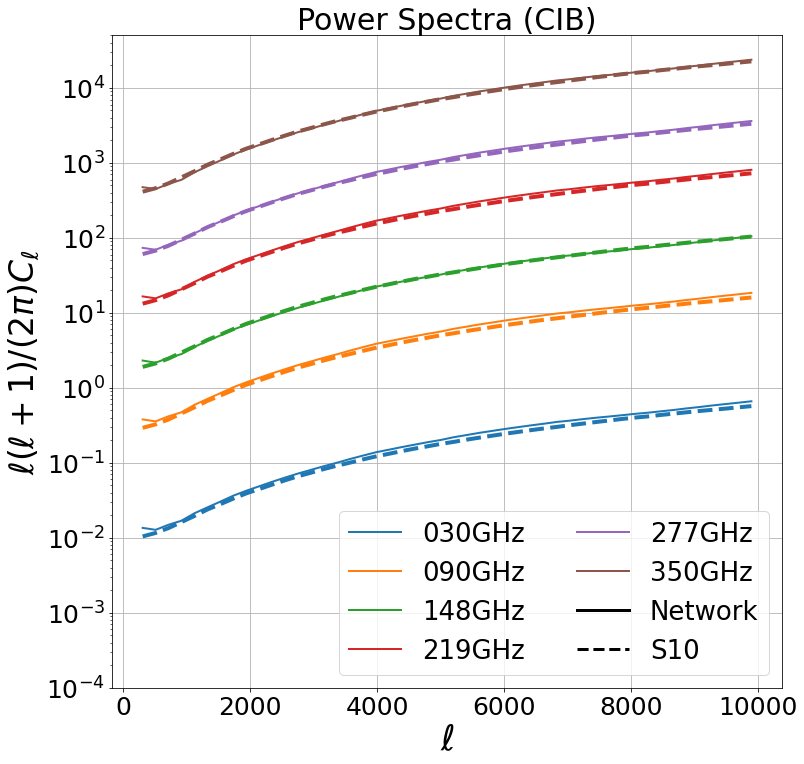

2133.55027735823
7.705780071458406
1
0.36959326346013655
0.3196446761563645
0.4519268468749922


<Figure size 432x288 with 0 Axes>

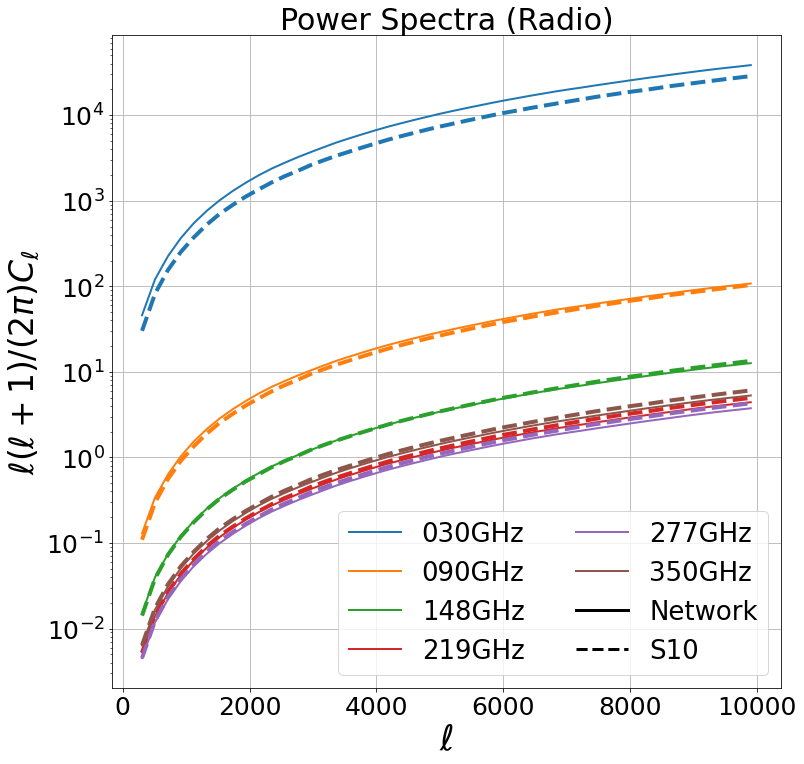

In [25]:
##ps

def key2label(key):
    storage = {"kappa":r"$  \kappa$ (x 100)",
               "ksz":"kSZ",
               "tsz":"tSZ",
               "ir":"CIB",
               "rad":"Radio",
              }
    return storage[key]


for key1 in compts[3:5]:
    flux_cut = True
    bin_edges = np.linspace(0,10000, 50)
    binner = mcm.PITAS_BINNER(bin_edges, lmax=10000)
    plt.clf()
    fig = plt.figure(figsize=(12,12))
    ax = fig.gca()
    lbin = binner.bin_center.copy()
    loc = np.where(lbin>200)
    
    for freq in SN.freqs:
        color = next(ax._get_lines.prop_cycler)['color']
        key2 = key1
        key = [key1, key2]
        key.sort()

        
        

        multi_fact = 1e4 if key1 == "kappa" else 1

        skey = f"dls_148_"+"x".join(key)
        dlbin = STAT_TEST_FC.stats[skey]["mean"]*multi_fact
        scaling_key = "tsz" if key1 == "tsz" else key1 + "_pts"
        scailing_fact = osehgal_scaling[scaling_key][freq]
        print(scailing_fact)
        
        plt.plot(lbin[loc], dlbin[loc]*scailing_fact, alpha=1, lw=4, marker="",markersize=8, color=color, ls="--")

        #dlbin =  STAT_GEN_FC.stats[key]["mean"]*multi_fact
        skey = f"dls_{freq:03d}_"+"x".join(key)
        dlbin =  STAT_GEN_FC.storage[skey][10]*multi_fact
        #print(STAT_GEN_FC.stats[key]["mean"]/STAT_TEST_FC.stats[key]["mean"])
        plt.plot(lbin[loc], dlbin[loc], alpha=1, lw=2, marker="",markersize=12, color=color, ls="-",
                label=f"{freq:03d}GHz")

        '''
        dl = fg_specs[key]*multi_fact
        l = np.arange(len(dl))
        plt.plot(l,dl, ls=":", color=color)
        '''
    #plt.plot([],[], lw=3, label=key2label(key1), color=color)
    #color = "darkblue" #next(ax._get_lines.prop_cycler)['color']
    #color = next(ax._get_lines.prop_cycler)['color']
    plt.title(f"Power Spectra ({key2label(key1)})", fontsize=30)
    plt.plot([],[], lw=3, marker="", ls="-", label="Network",  color="k")    
    plt.plot([],[], lw=3, marker="", label="S10", color="k", ls="--")
    ax.set_ylabel(r"$\ell(\ell+1)/(2\pi )C_\ell$", fontsize=33)
    ax.set_xlabel(r"$\ell$", fontsize=35)
    plt.legend(fontsize=26, ncol=2)
    


    ax.tick_params(axis='both', which='major', labelsize=25)
    ax.tick_params(axis='both', which='minor', labelsize=25)
    #ax.axvline(x=200, ls=":", color="k")
    if "ir" in key1:
        plt.ylim(1e-4, 5e4)
    ax.set_yscale("log")
    ax.grid()
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.savefig(plot_path(f"042121_{key1}_freqs.pdf"), bbox_inches='tight')
    plt.show()
    

/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


('kappa', 'tsz')
kappa tsz
kappa tsz
('kappa', 'ir')
kappa ir
kappa ir
('kappa', 'rad')
kappa rad
kappa rad
('ir', 'tsz')
ir tsz
ir tsz


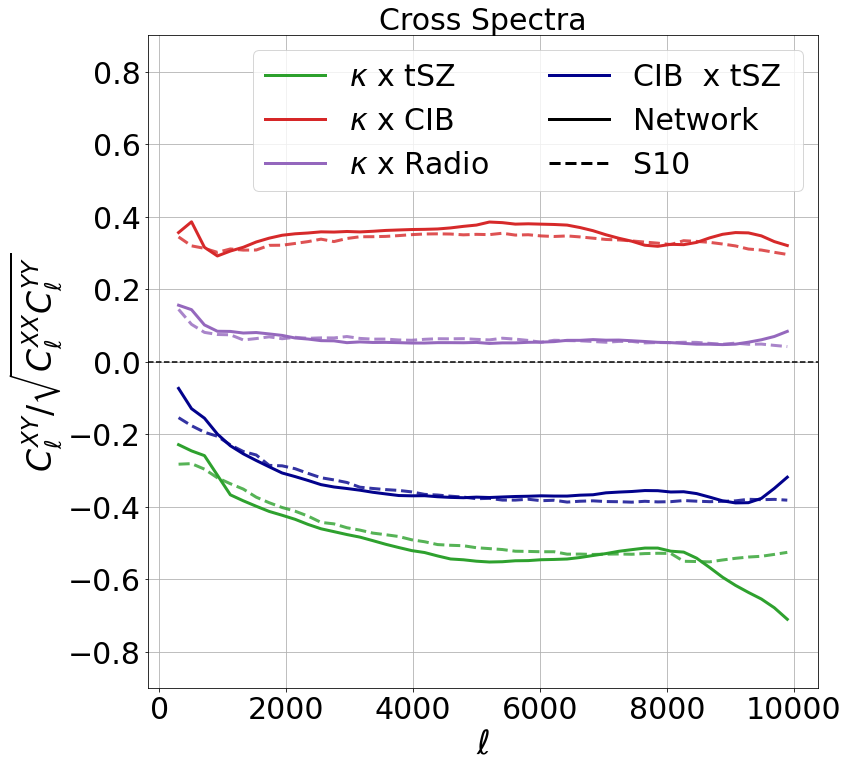

In [15]:
def get_correlation(STAT, key1, key2, postfix=""):
    print(key1, key2)
    key = [key1, key2]
    key.sort()
    key = "dls_148_"+"x".join(key)+postfix
    
    dls_x = STAT.stats[key]["mean"].copy()

    key = "dls_148_"+"x".join([key1, key1])+postfix
    dls_1 = STAT.stats[key]["mean"].copy()

    key = "dls_148_"+"x".join([key2, key2])+postfix
    dls_2 = STAT.stats[key]["mean"].copy()

    return dls_x/np.sqrt(dls_1*dls_2)

def key2label(key):
    storage = {"kappa":r"$\kappa$",
               "ksz":"kSZ ",
               "tsz":"tSZ ",
               "ir":"CIB ",
               "rad":"Radio",
              }
    return storage[key]
    
flux_cut = True
fig = plt.figure(figsize=(12,12))
ax = fig.gca()

color = next(ax._get_lines.prop_cycler)['color']
color = next(ax._get_lines.prop_cycler)['color']
for pair in [ ("kappa", "tsz"),("kappa", "ir"),("kappa", "rad"),("ir", "tsz")]:#, ("ir", "tsz")]:
    print(pair)
    key1, key2 = pair

    lbin = STAT_GEN_FC.storage["lbin"][0]
    color = next(ax._get_lines.prop_cycler)['color']
    if key1 == "ir": color="darkblue"
    
    rho = get_correlation(STAT_TEST if not flux_cut else STAT_TEST_FC, key1, key2)
    ax.plot(lbin[loc], rho[loc], alpha=0.8,  ls="--", lw=3, marker="", markersize=10, color=color)
    rho = get_correlation(STAT_GEN if not flux_cut else STAT_GEN_FC, key1, key2, "")
    ax.plot(lbin[loc], rho[loc], alpha=3,  ls="-", lw=3, marker="", markersize=10, color=color)
    plt.plot([],[], label="{}".format(" x ".join([key2label(key1), key2label(key2)])), lw=3, color=color)

plt.plot([],[], ls="-", lw=3, label="Network", color="k", markersize=30)
plt.plot([],[], ls="--", lw=3, label="S10", color="k", markersize=30)
plt.title("Cross Spectra", fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=30)
ax.tick_params(axis='both', which='minor', labelsize=30)
plt.ylabel(r"$C_{\ell}^{XY}/\sqrt{C_{\ell}^{XX}C_{\ell}^{YY}}$", fontsize=33)
#plt.ylabel(r"$\rho$", fontsize=33)
plt.xlabel(r"$\ell$", fontsize=33)
plt.ylim(-0.9,0.9)
plt.grid()
#plt.axvline(x=200, ls=":", color="k")
plt.axhline(y=0, ls="--", color="k")
plt.legend(fontsize=30, ncol=2)
plt.savefig(plot_path(f"030921_cross_full.pdf"), bbox_inches='tight')
plt.show()

additional = False
if additional:    
    flux_cut = True
    for i in range(5-3):
        fig = plt.figure(figsize=(12,12))
        ax = fig.gca()
        for j in range(i+1,3):
            key1, key2 = compts[i], compts[j]
            lbin = STAT_GEN_FC.storage["lbin"][0]
            color = next(ax._get_lines.prop_cycler)['color']
            rho = get_correlation(STAT_TEST if not flux_cut else STAT_TEST_FC, key1, key2)
            plt.plot(lbin[loc], rho[loc], alpha=0.8,  ls="--", lw=3, marker="", markersize=10, color=color)

            rho = get_correlation(STAT_GEN if not flux_cut else STAT_GEN_FC, key1, key2, "")
            plt.plot(lbin[loc], rho[loc], alpha=1,  ls="-", lw=3, marker="", markersize=10, color=color)
            plt.plot([],[], label="{}".format(" x ".join([key2label(key1), key2label(key2)])), color=color)
        plt.plot([],[], ls="-", lw=3, label="Network", color="k", markersize=10)
        plt.plot([],[], ls="--", lw=3, label="S10", color="k", markersize=10)
        plt.title("Cross Spectra", fontsize=20)
        ax.tick_params(axis='both', which='major', labelsize=30)
        ax.tick_params(axis='both', which='minor', labelsize=30)
        plt.ylabel(r"$\rho$", fontsize=33)
        plt.xlabel(r"$\ell$", fontsize=33)
        plt.ylim(-0.9,0.9)
        plt.grid()
        #plt.axvline(x=200, ls=":", color="k")
        plt.axhline(y=0, ls="--", color="k")
        plt.legend(fontsize=30, loc="upper right", ncol=2)
        plt.savefig(plot_path(f"030921_cross_{i}.pdf"), bbox_inches='tight')
        plt.show()

In [16]:
nbins = 10000

overwrite = False
if overwrite:
    real_hist = {}
    gen_hist = {}
    S10R = sehgal.Sehgal10ReprojectedFromCat(input_dir, SN.shape[-2:], SN.wcs)
    compts = ["kappa", "ksz", "tsz", "ir", "rad"]
    real_map = S10R.get_maps(0,0,ret_alm=False,flux_cut=7, load_processed=False)
    sim_idx = 10
    gen_map =  SN.get_foreground(sim_idx, freq=148)
    for i, compt_idx in enumerate(compts[:5]):
        rtemp = real_map[i]/np.std(real_map[i])
        gtemp = gen_map[i]/np.std(gen_map[i])

        rmax = np.max(rtemp)
        gmax = np.max(gtemp)
        tmax = np.max([rmax, gmax])

        rmin = np.min(rtemp)
        gmin = np.min(gtemp)
        tmin = np.min([rmin, gmin])

        print(i, compt_idx, tmin, tmax)
        FB = stats.FastBINNER(tmin, tmax, nbins)
        bin_center, rhist = FB.bin(rtemp)
        FB = stats.FastBINNER(tmin, tmax, nbins)
        bin_center, ghist = FB.bin(gtemp)
        print(rhist-ghist)

        real_hist[compt_idx] = {}
        real_hist[compt_idx]["bin_centers"] = bin_center
        real_hist[compt_idx]["hist"] = rhist
        gen_hist[compt_idx] = {}
        gen_hist[compt_idx]["bin_centers"] = bin_center
        gen_hist[compt_idx]["hist"] = ghist

    print("Done")
    np.savez("/home/dwhan89/workspace/cosmikyu/data/sehgal/030921_onept_real_full_{}.npz".format(nbins), **real_hist)
    np.savez("/home/dwhan89/workspace/cosmikyu/data/sehgal/030921_onept_gen_full_{}.npz".format(nbins), **gen_hist)
else:
    real_hist = cutils.load_data("/home/dwhan89/workspace/cosmikyu/data/sehgal/030921_onept_real_full_{}.npz".format(nbins))
    gen_hist = cutils.load_data("/home/dwhan89/workspace/cosmikyu/data/sehgal/030921_onept_gen_full_{}.npz".format(nbins))

/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<>:8: DeprecationWarning: invalid escape sequence \k
<>:8: DeprecationWarning: invalid escape sequence \k
<>:8: DeprecationWarning: invalid escape sequence \k
<ipython-input-17-851bab48d6e3>:8: DeprecationWarning: invalid escape sequence \k
  storage = {"kappa":"$\kappa $",


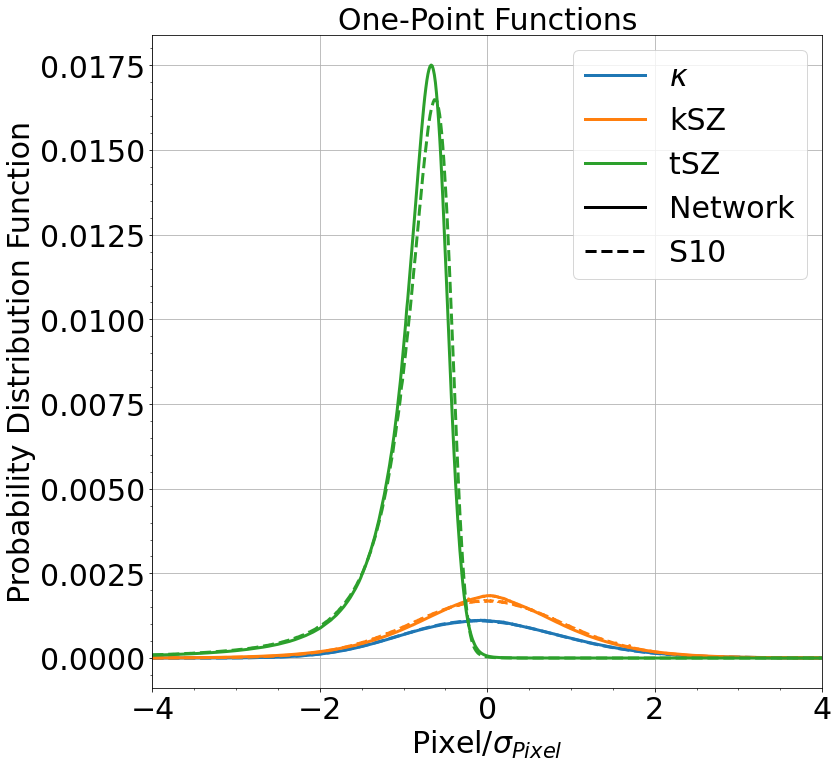

In [17]:
nbins = 10000

model =  cutils.load_data(
    "/home/dwhan89/workspace/cosmikyu/data/sehgal/030921_onept_real_full_{}.npz".format(nbins))
generated = cutils.load_data(
    "/home/dwhan89/workspace/cosmikyu/data/sehgal/030921_onept_gen_full_{}.npz".format(nbins))
def key2label(key):
    storage = {"kappa":"$\kappa $",
               "ksz":"kSZ",
               "tsz":"tSZ ",
               "ir":"CIB ",
               "rad":"Radio",
              }
    return storage[key]
nbins = 10000
fig = plt.figure(figsize=(12, 12))
ax = fig.gca()
for i, key in enumerate(compts[:3]):


    color = next(ax._get_lines.prop_cycler)['color']
    hist_generated = generated[key]['hist']
    bins_generated = generated[key]["bin_centers"]
    nsum_generated = np.sum(hist_generated)
    pdf_hist = hist_generated/nsum_generated
    if key == "ir":
        plt.plot(bins_generated[1:], pdf_hist[1:], alpha=1, lw=3, ls="-", color=color, label=key2label(key))
    else:
        plt.plot(bins_generated, pdf_hist, alpha=1, lw=3, ls="-", color=color, label=key2label(key))
        
    hist_model = model[key]['hist']
    bins_model = model[key]["bin_centers"]
    nsum_model = np.sum(hist_model)
    pdf_model = hist_model/nsum_model
    if key == "ir":
        plt.plot(bins_model[1:], pdf_model[1:], alpha=1, ls="--", lw=3, color=color)
    else:
        plt.plot(bins_model, pdf_model, alpha=1, ls="--", lw=3, color=color)


plt.ylabel("Probability Distribution Function", fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=30)
ax.tick_params(axis='both', which='minor', labelsize=30)
plt.plot([],[], lw=3, marker="", ls="-", label="Network", color="k")    
plt.plot([],[], lw=3, marker="", label="S10", color="k", ls="--")
plt.legend(fontsize=30)
plt.title(r"One-Point Functions", fontsize=30)
plt.xlabel(r"Pixel/$\sigma_{Pixel}$", fontsize=30)
plt.xlim(-4,4)
#plt.yscale("log")
#plt.ylim(1e-1,0.25)
plt.minorticks_on()
ax.tick_params(axis='x', which='minor', bottom=True)
plt.grid()
plt.savefig(plot_path(f"030921_one_point_full.pdf"), bbox_inches='tight')
plt.show()

/home/dwhan89/workspace/cosmikyu/cosmikyu/sehgal.py:214: RuntimeWarning: invalid value encountered in true_divide
  specs[key] = np.nan_to_num(specs[key] / l_fact)


cmbonly
full
rad
ksz
tsz
ir


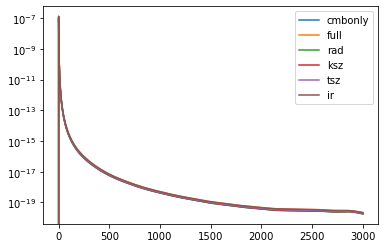

In [7]:
output_file = output_path("mlsimsv0.2_als_fullsky_lownoise.npz")
overwrite = True
if not os.path.exists(output_file) or overwrite:
    al_recon = {}
    #mlsims_1d_transf = {}
    
    Tcmb  = 2.726e6    # CMB temperature
    Lmax  = 3000       # maximum multipole of output normalization
    lmax  = 3000
    rlmin, rlmax = 100, 3000  # CMB multipole range for reconstruction
    L = np.linspace(0,Lmax,Lmax+1)
    l = L.copy()
    Lfac = (L*(L+1.))**2/(4)
    
    lensed_spec_file = "/home/dwhan89/scratch/data/sehgal_et_al_sims/theoryCls/bode_almost_wmap5_lmax_1e4_lensedCls.dat"
    lcl = np.zeros((4,lmax+1)) # TT, EE, BB, TE
    lcl[:,2:] = np.loadtxt(lensed_spec_file,unpack=True,usecols=(1,2,3,4))[:,:lmax-1] 
    lcl *= 2.*np.pi / (l**2+l+1e-30) #/ Tcmb**2 


    noise_level = 0.01
    Nt = cosmology.white_noise_with_atm_func(l, noise_level, 0, 0, False)
    Np = Nt*2
    ntp = Nt*0
    f_beam = s.utils.gauss_beam(l, 0.01)
    
    
    S10R = sehgal.Sehgal10ReprojectedFromCat(input_dir, SN.shape[-2:], SN.wcs)
    compts = ["kappa", "ksz", "tsz", "ir", "rad"]
    fg_specs = S10R.get_specs(ret_dl=False, flux_cut=7, overwrite=False)
    
    QDO = [True,False,False,False,False,False] # this means that TT, TE, EE, TB and EB are used for MV estimator
    
    modes = ["cmbonly", "full", "rad", "ksz", "tsz", "ir"]
    for mode in modes:
        print(mode)
        fg_idxes = []
        assert(mode in modes)
        if mode == "cmbonly":
            fg_processed = l*0
        else:
            if mode == "ksz": 
                fg_full = fg_specs["dls_kszxksz"]
                fg_idxes=[1]
            elif mode == "tsz":
                fg_full = fg_specs["dls_tszxtsz"]
                fg_idxes=[2]
            elif mode == "ir":
                fg_full = fg_specs["dls_irxir"]
                fg_idxes=[3]
            elif mode == "rad":
                fg_full = fg_specs["dls_radxrad"]
                fg_idxes=[4]
            elif mode == "full":
                fg_full = fg_specs["dls_irxir"]
                fg_specs["dls_radxrad"]+fg_specs["dls_kszxksz"]+fg_specs["dls_tszxtsz"]+fg_specs["dls_irxir"]
                fg_idxes=[1,2,3,4]
            fg_processed = scipy.ndimage.gaussian_filter1d(fg_full, sigma=5); del fg_full
        ocl = lcl.copy()
        ocl[0] = ocl[0]+(fg_processed[:lmax+1]+Nt/f_beam)#/ Tcmb**2 
        ocl[1] = ocl[1]+(Np/f_beam)#/ Tcmb**2 
        ocl[2] = ocl[2]+(Np/f_beam)#/ Tcmb**2 
        ocl[3] = ocl[3]
        
        #lt.plot(lcl[0])
        #lt.plot(ocl[0])
        #plt.yscale("log")
        
        Ag, Ac, Wg, Wc = cs.norm_lens.qall(QDO,Lmax,rlmin,rlmax,lcl,ocl)
        #rint("here")
        al_recon["L"] = L 
        al_recon[mode] = Ag[0]
        
        plt.plot(L, Ag[0],label=mode)
        plt.yscale("log")
        plt.legend()
        
    #del template, modlmap, nshape, nwcs
    np.savez(output_file, **al_recon)
else:
    al_recon = np.load(output_file)

[STATS] output_dir is /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues


/home/dwhan89/workspace/cosmikyu/cosmikyu/sehgal.py:214: RuntimeWarning: invalid value encountered in true_divide
  specs[key] = np.nan_to_num(specs[key] / l_fact)


Loading sims
loading /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/kappa_alm_000_000_000.fits
loading /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/148_ksz_alm_000_000_000.fits
loading /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/148_tsz_alm_000_000_000.fits
loading /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/148_ir_pts_enmap_000_000_000.fits
loading /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/148_rad_pts_enmap_000_000_000.fits
starting recon s10 cmbonly
running falefal s10 cmbonly
finished running falefal s10 cmbonly


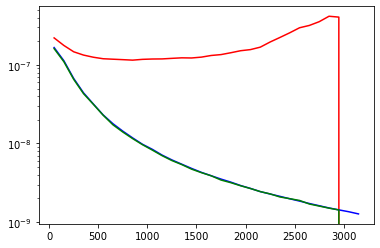

[STATS] collecting data
[STATS] saving /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/stats_030921_4ptv5_lownoise.npz from root 0
[STATS] loaded /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/stats_030921_4ptv5_lownoise.npz
Loading sims
trying to load saved foregrounds. sim idx: 2, freq: 148GHz
trying to load saved lensed cmb. sim idx: 2
starting recon mlsims cmbonly
running falefal mlsims cmbonly
finished running falefal mlsims cmbonly


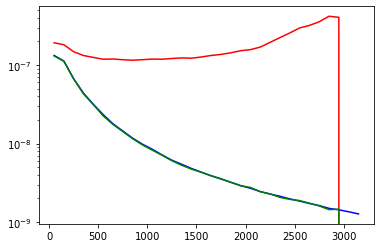

[STATS] collecting data
[STATS] saving /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/stats_030921_4ptv5_lownoise.npz from root 0
[STATS] loaded /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/stats_030921_4ptv5_lownoise.npz


In [13]:
from falafel import qe

overwrite = True
show_plot = True
#st_4pt = stats.STATS("030921_4ptv2", output_dir=input_dir, overwrite=overwrite)
st_4pt = stats.STATS("030921_4ptv5_lownoise", output_dir=input_dir, overwrite=overwrite)
lmin = 100
lmax = 3000
mlmax = lmax+200
Lmax = mlmax 
lensed_spec_file = "/home/dwhan89/scratch/data/sehgal_et_al_sims/theoryCls/bode_almost_wmap5_lmax_1e4_lensedCls.dat"
l = np.arange(mlmax+1)
ps_len = powspec.read_spectrum(lensed_spec_file)
ps_len = ps_len[...,:mlmax+1]

L = np.arange(lmax+1)
Lfac = (L*(L+1.))**2/4

noise_level = 0.01
Nt = cosmology.white_noise_with_atm_func(l, noise_level, 0, 0, False)
Np = Nt*2
ntp = Nt*0
f_beam = s.utils.gauss_beam(l, 0.01)

#bin_edges = np.linspace(0,mlmax,50)
bin_edges = np.linspace(0,3200,33)

binner = mcm.PITAS_BINNER(bin_edges, lmax=mlmax)

S10R = sehgal.Sehgal10ReprojectedFromCat(input_dir, SN.shape[-2:], SN.wcs)
compts = ["kappa", "ksz", "tsz", "ir", "rad"]
fg_specs = S10R.get_specs(ret_dl=False, flux_cut=7, overwrite=False)


for sim_type in ["s10", "mlsims"]:

    mode = "ir"
    spec_type = "clkkx"
    sim_idx  = 0 if sim_type == "s10" else 0
    st_idx = f"{sim_type}_%s_{mode}" %spec_type
    if st_4pt.has_data(st_idx, sim_idx): continue
    
    px = qe.pixelization(shape=SN.shape,wcs=SN.wcs)
    #nmap = curvedsky.rand_map(SN.shape, SN.wcs, Nt/f_beam**2, seed=123123)
    nalm = curvedsky.rand_alm((Nt/f_beam), seed=123123)
    print("Loading sims")
    if sim_type == "s10":
        fgmaps = np.float64(S10R.get_maps(0,0,ret_alm=False,flux_cut=7, load_processed=False))
        fgalms = curvedsky.map2alm(fgmaps, lmax=mlmax, spin=0); del fgmaps
        tmap = np.float64(enmap.read_map(output_path(f"m10r_{sim_idx:05}_lcmbv2.fits"))[0]) 
        talm = curvedsky.map2alm(tmap, lmax=mlmax); del tmap
        ikappa_alm = fgalms[0]
    elif sim_type == "mlsims":
        fgmaps = SN.get_foreground(2)#np.float64(enmap.read_map(output_path(f"mlsimsv0.12_{sim_idx:05}_processed.fits")))
        fgalms = curvedsky.map2alm(fgmaps, lmax=mlmax, spin=0); del fgmaps
        tmap = SN.get_lensed_cmb(2)[0]#np.float64(enmap.read_map(output_path(f"mlsimsv0.12_{sim_idx:05}_lcmb.fits"))[0])
        talm = curvedsky.map2alm(tmap, lmax=mlmax, spin=0); del tmap
        ikappa_alm = fgalms[0]
    else:
        assert(False)
    modes = ["cmbonly"]#, "ksz", "tsz", "full", "rad", "ir"]
    for mode in modes:
        spec_type = "clkkx"
        st_idx_template = f"{sim_type}_%s_{mode}" 
        if st_4pt.has_data(st_idx_template%spec_type, sim_idx): continue
        print(f"starting recon {sim_type} {mode}")
        fg_idxes = []
        assert(mode in modes)
        if mode == "cmbonly":
            fg_processed = l*0
        else:
            if mode == "ksz": 
                fg_full = fg_specs["dls_kszxksz"]
                fg_idxes=[1]
            elif mode == "tsz":
                fg_full = fg_specs["dls_tszxtsz"]
                fg_idxes=[2]
            elif mode == "ir":
                fg_full = fg_specs["dls_irxir"]
                fg_idxes=[3]
            elif mode == "rad":
                fg_full = fg_specs["dls_radxrad"]
                fg_idxes=[4]
            elif mode == "full":
                fg_full = fg_specs["dls_irxir"]+fg_specs["dls_radxrad"]+fg_specs["dls_kszxksz"]+fg_specs["dls_tszxtsz"]
                fg_idxes=[1,2,3,4]
            fg_processed = scipy.ndimage.gaussian_filter1d(fg_full, sigma=5); del fg_full

        fgalm = nalm * 0 if mode == "cmbonly" else np.sum(fgalms[fg_idxes,...], axis=0)
        falm = talm + fgalm + nalm
        
        noise = Nt/f_beam+fg_processed[:mlmax+1]
        wfilt = 1/(ps_len[0,0]+noise)
        wfilt[:2] = 0.
        falm =  qe.filter_alms(falm, wfilt, lmin= 100, lmax=lmax)
        print(f"running falefal {sim_type} {mode}")
        rphi_alm = qe.qe_all(px,{'TT':ps_len[0,0]},mlmax,falm,None,None,estimators=['TT'], xfTalm=None)['TT']
        rkappa_alm = curvedsky.almxfl(rphi_alm[0], al_recon[mode]*np.sqrt(Lfac)); del rphi_alm
        
        print(f"finished running falefal {sim_type} {mode}")
        clkkr = hp.alm2cl(rkappa_alm)
        L = np.arange(len(clkkr))
        lbin, clkkr_bin = binner.bin(L, clkkr)
        
        clkki = hp.alm2cl(ikappa_alm)
        L = np.arange(len(clkki))
        lbin, clkki_bin = binner.bin(L, clkki)
        
        clkkx = hp.alm2cl(rkappa_alm, ikappa_alm)
        L = np.arange(len(clkkx))
        lbin, clkkx_bin = binner.bin(L, clkkx)

        spec_type = "clkkr"
        st_4pt.add_data(st_idx_template%spec_type, sim_idx, clkkr_bin)
        spec_type = "clkki"
        st_4pt.add_data(st_idx_template%spec_type, sim_idx, clkki_bin)
        spec_type = "clkkx"
        st_4pt.add_data(st_idx_template%spec_type, sim_idx, clkkx_bin)
        st_4pt.add_data("lbin", 0, lbin)
        
        if show_plot:
            plt.plot(lbin, clkkr_bin, color="r")
            plt.plot(lbin, clkki_bin, color="b")
            plt.plot(lbin, clkkx_bin, color="g")
            plt.yscale("log")
            plt.show()
        
        st_4pt.save_data()

<Figure size 432x288 with 0 Axes>

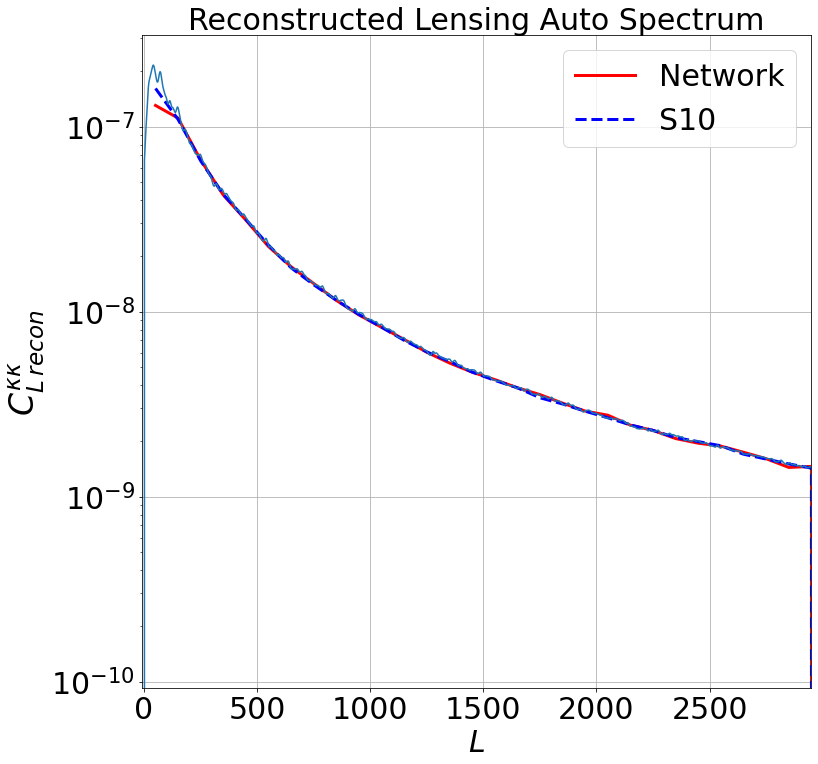

In [14]:
clkk = np.load("/home/dwhan89/scratch/data/sehgal_et_al_sims/theoryCls/clkk_sim.npy")
ell = np.arange(len(clkk))
l_fact = ((ell*ell+1)/2)**2
lbin = st_4pt.storage["lbin"][0]
plt.clf()
fig = plt.figure(figsize=(12,12))
ax = fig.gca()

loc = lbin>50
plt.plot(lbin[loc], st_4pt.storage["mlsims_clkkx_cmbonly"][0][loc], lw=3, marker="", ls="-", color="r",
         label="Network")
plt.plot(lbin[loc], st_4pt.storage["s10_clkkx_cmbonly"][0][loc], lw=3, marker="",ls="--", color="b", label="S10")
plt.plot(clkk[:,0],clkk[:,1])
plt.title(r"Reconstructed Lensing Auto Spectrum",
          fontsize=30)
ax.set_xlabel(r"$L$", fontsize=30)
ax.set_ylabel(r"$C_{L\: recon}^{\kappa\kappa}$", fontsize=33)
plt.legend(fontsize=30, ncol=1)

ax.tick_params(axis='both', which='major', labelsize=30)
ax.tick_params(axis='both', which='minor', labelsize=30)
ax.grid()
plt.subplots_adjust(wspace=0, hspace=0)
plt.yscale("log")
plt.xlim(-10,2950)
#plt.savefig(plot_path("050521_kreconxinput.pdf"), bbox_inches = 'tight')


plt.show()

<Figure size 432x288 with 0 Axes>

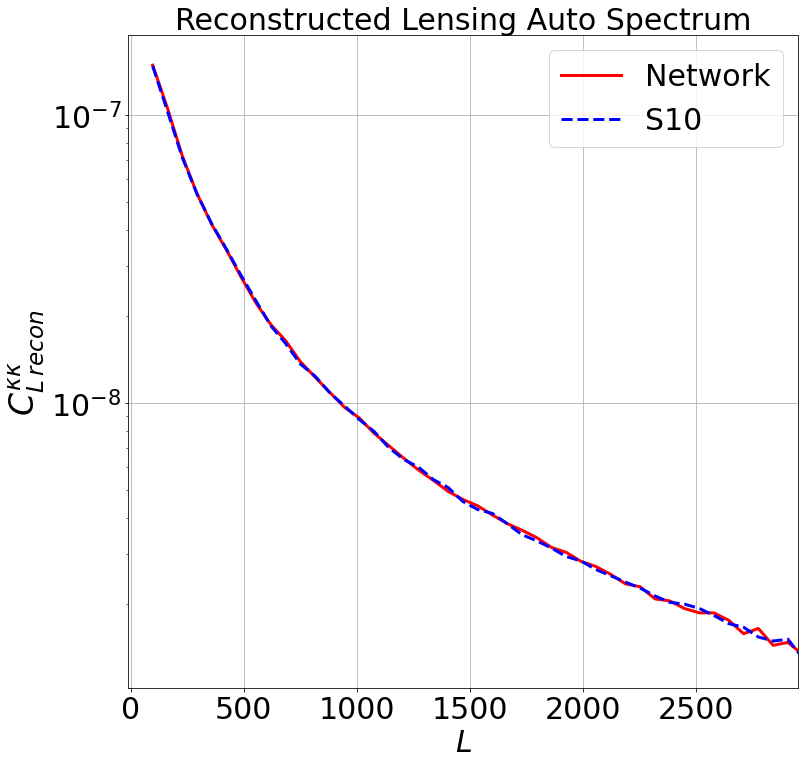

In [10]:
clkk = np.load("/home/dwhan89/scratch/data/sehgal_et_al_sims/theoryCls/clkk_sim.npy")
ell = np.arange(len(clkk))
l_fact = ((ell*ell+1)/2)**2
lbin = st_4pt.storage["lbin"][0]
plt.clf()
fig = plt.figure(figsize=(12,12))
ax = fig.gca()

loc = lbin>50
plt.plot(lbin[loc], st_4pt.storage["mlsims_clkkx_cmbonly"][0][loc], lw=3, marker="", ls="-", color="r",
         label="Network")
plt.plot(lbin[loc], st_4pt.storage["s10_clkkx_cmbonly"][0][loc], lw=3, marker="",ls="--", color="b", label="S10")
plt.title(r"Reconstructed Lensing Auto Spectrum",
          fontsize=30)
ax.set_xlabel(r"$L$", fontsize=30)
ax.set_ylabel(r"$C_{L\: recon}^{\kappa\kappa}$", fontsize=33)
plt.legend(fontsize=30, ncol=1)

ax.tick_params(axis='both', which='major', labelsize=30)
ax.tick_params(axis='both', which='minor', labelsize=30)
ax.grid()
plt.subplots_adjust(wspace=0, hspace=0)
plt.yscale("log")
plt.xlim(-10,2950)
#plt.savefig(plot_path("030921_kreconxinput.pdf"), bbox_inches = 'tight')


plt.show()

/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarni

<Figure size 432x288 with 0 Axes>

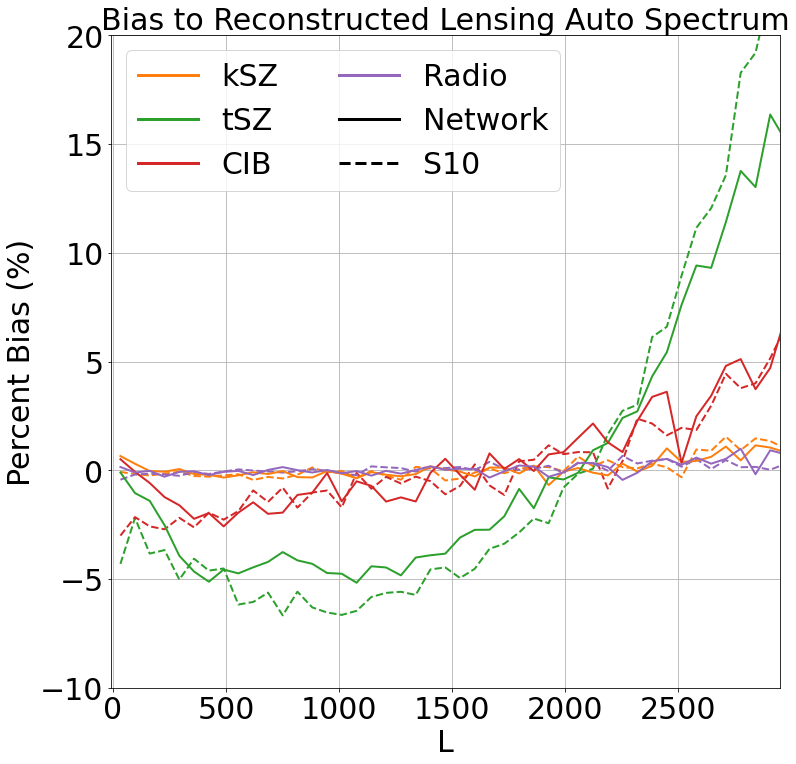

In [8]:
lbin = st_4pt.storage["lbin"][0]
plt.clf()
fig = plt.figure(figsize=(12,12))
ax = fig.gca()

colors = [None]*6
for i in range(6):
    colors[i] = next(ax._get_lines.prop_cycler)['color']
colors[5] = "darkblue"
vkey = "s10"
ref = st_4pt.storage["%s_clkkx_cmbonly" %vkey][0]
plt.plot(lbin, (st_4pt.storage["%s_clkkx_ksz" %vkey][0]-ref)/ref*100, lw=2, ls="--", color=colors[1])
plt.plot(lbin, (st_4pt.storage["%s_clkkx_tsz" %vkey][0]-ref)/ref*100, lw=2, ls="--", color=colors[2])
plt.plot(lbin, (st_4pt.storage["%s_clkkx_ir" %vkey][0]-ref)/ref*100, lw=2, ls="--", color=colors[3])
plt.plot(lbin, (st_4pt.storage["%s_clkkx_rad" %vkey][0]-ref)/ref*100, lw=2, ls="--", color=colors[4])
#plt.plot(lbin, (st_4pt.storage["%s_clkkx_full" %vkey][0]-ref)/ref*100, lw=2, ls="--", color=colors[5])

vkey = "mlsims"
ref = st_4pt.storage["%s_clkkx_cmbonly" %vkey][0]
plt.plot(lbin, (st_4pt.storage["%s_clkkx_ksz" %vkey][0]-ref)/ref*100, lw=2, ls="-", color=colors[1])
plt.plot(lbin, (st_4pt.storage["%s_clkkx_tsz" %vkey][0]-ref)/ref*100, lw=2, ls="-", color=colors[2])
plt.plot(lbin, (st_4pt.storage["%s_clkkx_ir" %vkey][0]-ref)/ref*100, lw=2, ls="-", color=colors[3])
plt.plot(lbin, (st_4pt.storage["%s_clkkx_rad" %vkey][0]-ref)/ref*100, lw=2, ls="-", color=colors[4])
#plt.plot(lbin, (st_4pt.storage["%s_clkkx_full" %vkey][0]-ref)/ref*100, lw=2, ls="-", color=colors[5])

plt.plot([],[],ls="-", color=colors[1], lw=3, label="kSZ")
plt.plot([],[],ls="-", color=colors[2], lw=3, label="tSZ")
plt.plot([],[],ls="-", color=colors[3], lw=3, label="CIB")
plt.plot([],[],ls="-", color=colors[4], lw=3, label="Radio")
#plt.plot([],[],ls="-", color=colors[5], lw=3, label="All FGs")
plt.plot([],[],ls="-", color="k", lw=3, label="Network")
plt.plot([],[],ls="--", color="k", lw=3, label="S10")
plt.plot([],[],ls="", color="k", lw=2, label="")
#plt.axhline(y=0, color="k", ls="-", lw=3)
plt.title(r"Bias to Reconstructed Lensing Auto Spectrum", fontsize=30)
ax.set_xlabel(r"L", fontsize=30)
ax.set_ylabel("Percent Bias (%)", fontsize=30)
handles, labels = plt.gca().get_legend_handles_labels()
#order = [0,1,2,3,4,5,6]
order = [0,1,2,3,4,5]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=30, ncol=2)

ax.tick_params(axis='both', which='major', labelsize=30)
ax.tick_params(axis='both', which='minor', labelsize=30)
ax.grid()
plt.subplots_adjust(wspace=0, hspace=0)
plt.ylim(-0.10*100,0.20*100)
plt.xlim(-10,2950)
plt.savefig(plot_path("050521_frac_bias_fgs.pdf"), bbox_inches = 'tight')
#plt.ylim(2e-2, 5e3)

plt.show()

/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as a

<Figure size 432x288 with 0 Axes>

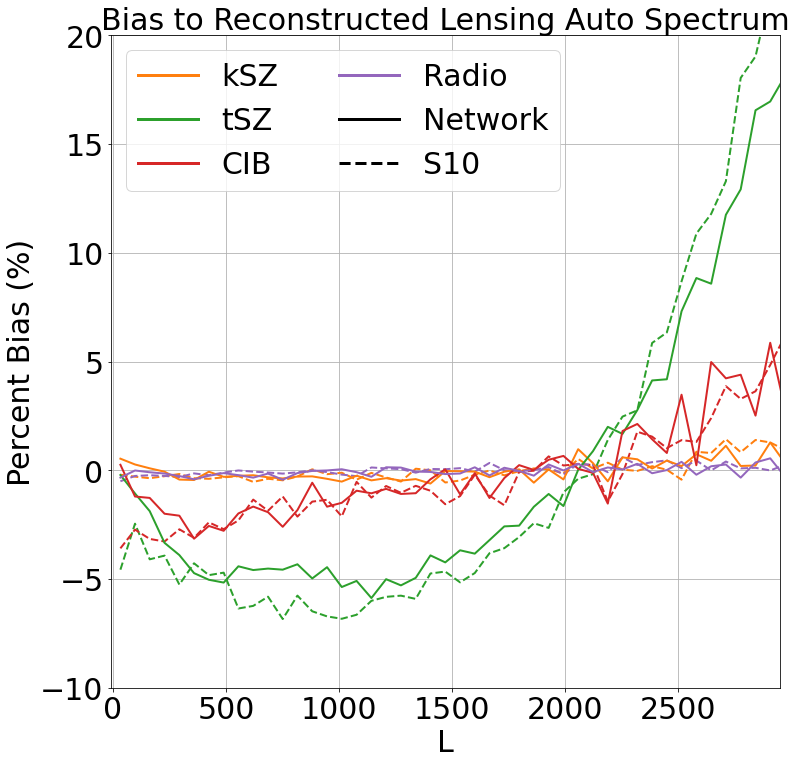

In [21]:
lbin = st_4pt.storage["lbin"][0]
plt.clf()
fig = plt.figure(figsize=(12,12))
ax = fig.gca()

colors = [None]*6
for i in range(6):
    colors[i] = next(ax._get_lines.prop_cycler)['color']
colors[5] = "darkblue"
vkey = "s10"
ref = st_4pt.storage["%s_clkkx_cmbonly" %vkey][0]
plt.plot(lbin, (st_4pt.storage["%s_clkkx_ksz" %vkey][0]-ref)/ref*100, lw=2, ls="--", color=colors[1])
plt.plot(lbin, (st_4pt.storage["%s_clkkx_tsz" %vkey][0]-ref)/ref*100, lw=2, ls="--", color=colors[2])
plt.plot(lbin, (st_4pt.storage["%s_clkkx_ir" %vkey][0]-ref)/ref*100, lw=2, ls="--", color=colors[3])
plt.plot(lbin, (st_4pt.storage["%s_clkkx_rad" %vkey][0]-ref)/ref*100, lw=2, ls="--", color=colors[4])
#plt.plot(lbin, (st_4pt.storage["%s_clkkx_full" %vkey][0]-ref)/ref*100, lw=2, ls="--", color=colors[5])

vkey = "mlsims"
ref = st_4pt.storage["%s_clkkx_cmbonly" %vkey][0]
plt.plot(lbin, (st_4pt.storage["%s_clkkx_ksz" %vkey][0]-ref)/ref*100, lw=2, ls="-", color=colors[1])
plt.plot(lbin, (st_4pt.storage["%s_clkkx_tsz" %vkey][0]-ref)/ref*100, lw=2, ls="-", color=colors[2])
plt.plot(lbin, (st_4pt.storage["%s_clkkx_ir" %vkey][0]-ref)/ref*100, lw=2, ls="-", color=colors[3])
plt.plot(lbin, (st_4pt.storage["%s_clkkx_rad" %vkey][0]-ref)/ref*100, lw=2, ls="-", color=colors[4])
#plt.plot(lbin, (st_4pt.storage["%s_clkkx_full" %vkey][0]-ref)/ref*100, lw=2, ls="-", color=colors[5])

plt.plot([],[],ls="-", color=colors[1], lw=3, label="kSZ")
plt.plot([],[],ls="-", color=colors[2], lw=3, label="tSZ")
plt.plot([],[],ls="-", color=colors[3], lw=3, label="CIB")
plt.plot([],[],ls="-", color=colors[4], lw=3, label="Radio")
#plt.plot([],[],ls="-", color=colors[5], lw=3, label="All FGs")
plt.plot([],[],ls="-", color="k", lw=3, label="Network")
plt.plot([],[],ls="--", color="k", lw=3, label="S10")
plt.plot([],[],ls="", color="k", lw=2, label="")
#plt.axhline(y=0, color="k", ls="-", lw=3)
plt.title(r"Bias to Reconstructed Lensing Auto Spectrum", fontsize=30)
ax.set_xlabel(r"L", fontsize=30)
ax.set_ylabel("Percent Bias (%)", fontsize=30)
handles, labels = plt.gca().get_legend_handles_labels()
#order = [0,1,2,3,4,5,6]
order = [0,1,2,3,4,5]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=30, ncol=2)

ax.tick_params(axis='both', which='major', labelsize=30)
ax.tick_params(axis='both', which='minor', labelsize=30)
ax.grid()
plt.subplots_adjust(wspace=0, hspace=0)
plt.ylim(-0.10*100,0.20*100)
plt.xlim(-10,2950)
plt.savefig(plot_path("030921_frac_bias_fgs.pdf"), bbox_inches = 'tight')
#plt.ylim(2e-2, 5e3)

plt.show()

In [27]:
nbins = 100
s10rsims_hist_file = "/home/dwhan89/workspace/cosmikyu/data/sehgal/030921_histogram_real_full_{}_test.npz".format(nbins)
mlsims_hist_file = "/home/dwhan89/workspace/cosmikyu/data/sehgal/030921_histogram_gen_full_{}_test.npz".format(nbins)
overwrite = True

if not os.path.exists(mlsims_hist_file) or overwrite:   
    S10R = sehgal.Sehgal10ReprojectedFromCat(input_dir, SN.shape[-2:], SN.wcs)
    s10r_pts = S10R.get_maps(0,0, compts=["ir_pts", "rad_pts"], ret_alm=False, flux_cut=7)
    sim_idx = 10
    #sample = SN.get_foreground(1)#enmap.read_map(output_path(f"mlsimsv0.12_{sim_idx:05}_processed.fits"), wcs=SN.wcs)
    
    #sample = osample.copy()
    compts = ["kappa", "ksz", "tsz", "ir", "rad"]

    
    real_hist = {}
    gen_hist = {}

    pixsizemap = enmap.pixsizemap(SN.shape,SN.wcs)
    conv = (1/sehgal.jysr2thermo(148)*pixsizemap)*1e3

    for i, compt_idx in enumerate(['ir','rad']):
        #target = sample[i+3]*conv  if compt_idx == "ir" else map2*conv
        target = map3*conv  if compt_idx == "ir" else map2*conv
        ref = s10r_pts[i]*conv
        

        tmin, tmax = (-5,7)
        print(i, compt_idx, tmin, tmax)
        FB = stats.FastBINNER(tmin, tmax, nbins)
        bin_center, rhist = FB.bin(ref)
        FB = stats.FastBINNER(tmin, tmax, nbins)
        bin_center, ghist = FB.bin(target)

        real_hist[compt_idx] = {}
        real_hist[compt_idx]["bin_centers"] = bin_center
        real_hist[compt_idx]["hist"] = rhist
        gen_hist[compt_idx] = {}
        gen_hist[compt_idx]["bin_centers"] = bin_center
        gen_hist[compt_idx]["hist"] = ghist

        #del ref,target,loc

    #del s10r_pts, pixsizemap
    print("Done")
    np.savez(s10rsims_hist_file, **real_hist)
    np.savez(mlsims_hist_file, **gen_hist)
else:
    real_hist = cutils.load_data(mlsims_hist_file)
    gen_hist = cutils.load_data(mlsims_hist_file)

loading /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/148_ir_pts_enmap_000_000_000.fits
loading /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/148_rad_pts_enmap_000_000_000.fits
0 ir -5 7
1 rad -5 7
Done


In [12]:
    compts = ["kappa", "ksz", "tsz", "ir", "rad"]

    
    real_hist = {}
    gen_hist = {}

    pixsizemap = enmap.pixsizemap(SN.shape,SN.wcs)
    conv = (1/sehgal.jysr2thermo(148)*pixsizemap)*1e3

    for i, compt_idx in enumerate(['ir','rad']):
        if compt_idx == "ir": continue 
        target = map3*conv  if compt_idx == "ir" else map2*conv
        print("help")
        #enplot.plot(target[10000:12000,:500], downgrade=4)
        ref = s10r_pts[i]*conv
        

        tmin, tmax = (-7,7)
        print(i, compt_idx, tmin, tmax)
        FB = stats.FastBINNER(tmin, tmax, nbins)
        bin_center, rhist = FB.bin(ref)
        FB = stats.FastBINNER(tmin, tmax, nbins)
        bin_center, ghist = FB.bin(target)

        real_hist[compt_idx] = {}
        real_hist[compt_idx]["bin_centers"] = bin_center
        real_hist[compt_idx]["hist"] = rhist
        gen_hist[compt_idx] = {}
        gen_hist[compt_idx]["bin_centers"] = bin_center
        gen_hist[compt_idx]["hist"] = ghist

        #del ref,target,loc

    #del s10r_pts, pixsizemap
    print("Done")
    np.savez(s10rsims_hist_file, **real_hist)
    np.savez(mlsims_hist_file, **gen_hist)

help
1 rad -7 7
Done


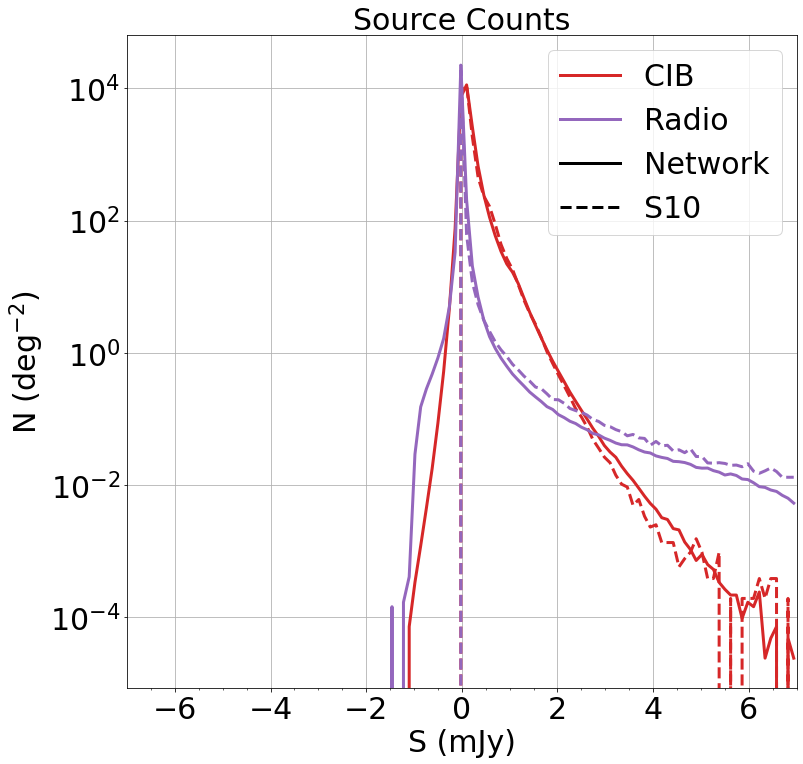

In [28]:
nbins = 100
s10rsims_hist_file = "/home/dwhan89/workspace/cosmikyu/data/sehgal/030921_histogram_real_full_{}_test.npz".format(nbins)
mlsims_hist_file = "/home/dwhan89/workspace/cosmikyu/data/sehgal/030921_histogram_gen_full_{}_test.npz".format(nbins)


model =  cutils.load_data(s10rsims_hist_file)
generated = cutils.load_data(mlsims_hist_file)

def key2label(key):
    storage = {"kappa":"$\kappa $",
               "ksz":"kSZ",
               "tsz":"tSZ ",
               "ir":"CIB ",
               "rad":"Radio",
              }
    return storage[key]

conv_fact = 1
area_fact = 41252.96125

fig = plt.figure(figsize=(12, 12))
ax = fig.gca()


for i in range(3):
    color = next(ax._get_lines.prop_cycler)['color']
for key in ["ir", "rad"]:
    
    color = next(ax._get_lines.prop_cycler)['color']
    #if key == "ir": continue
    hist_generated = generated[key]['hist']/area_fact
    bins_generated = generated[key]["bin_centers"]*conv_fact
    plt.plot(bins_generated, hist_generated, alpha=1, lw=3, ls="-", color=color, label=key2label(key))

    hist_model = model[key]['hist']/area_fact
    #cumsum_model /= area_fact
    bins_model = model[key]["bin_centers"]*conv_fact
    plt.plot(bins_model, hist_model, alpha=1, ls="--", lw=3, color=color)


plt.ylabel("N (deg$^{-2}$)", fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=30)
ax.tick_params(axis='both', which='minor', labelsize=30)
plt.plot([],[], lw=3, marker="", ls="-", label="Network", color="k")    
plt.plot([],[], lw=3, marker="", label="S10", color="k", ls="--")
plt.legend(fontsize=30)
plt.title(r"Source Counts", fontsize=30)
plt.xlabel(r"S (mJy)", fontsize=30)
plt.xlim(-7,7)
plt.yscale("log")
#plt.xscale("log")
#plt.ylim(2e-4,5e4)
plt.minorticks_on()
ax.tick_params(axis='x', which='minor', bottom=True)
plt.grid()
plt.savefig(plot_path(f"030921_source_counts.pdf"), bbox_inches='tight')
plt.show()

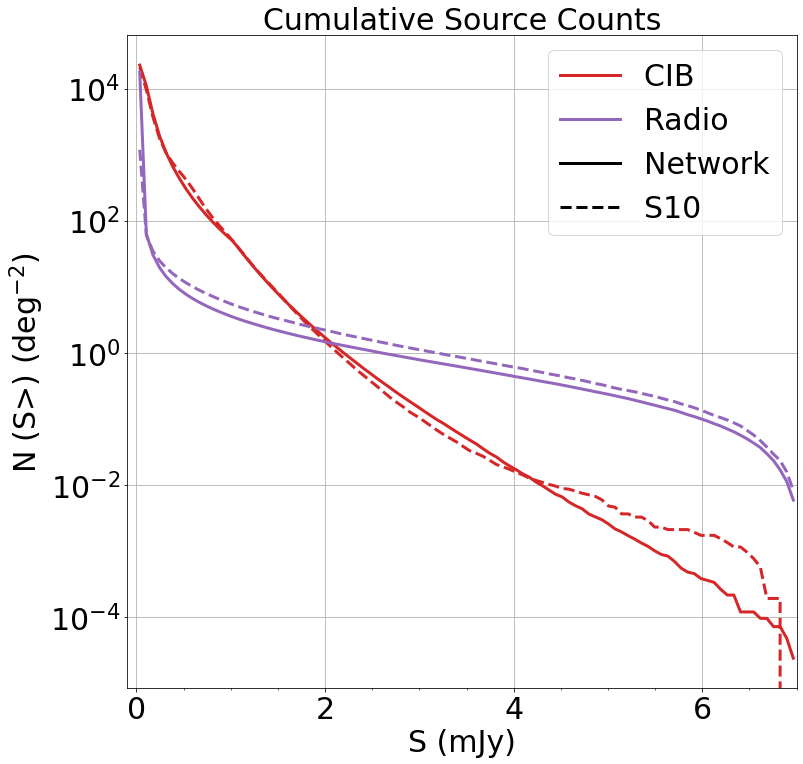

In [17]:
s10rsims_hist_file = "/home/dwhan89/workspace/cosmikyu/data/sehgal/030921_histogram_real_full_{}.npz".format(nbins)
mlsims_hist_file = "/home/dwhan89/workspace/cosmikyu/data/sehgal/030921_histogram_gen_full_{}.npz".format(nbins)


model =  cutils.load_data(s10rsims_hist_file)
generated = cutils.load_data(mlsims_hist_file)

def key2label(key):
    storage = {"kappa":"$\kappa $",
               "ksz":"kSZ",
               "tsz":"tSZ ",
               "ir":"CIB ",
               "rad":"Radio",
              }
    return storage[key]

conv_fact = 1
area_fact = 41252.96125

fig = plt.figure(figsize=(12, 12))
ax = fig.gca()


for i in range(3):
    color = next(ax._get_lines.prop_cycler)['color']
for key in ["ir", "rad"]:
    color = next(ax._get_lines.prop_cycler)['color']    
    hist_generated = generated[key]['hist']
    cumsum_generated = np.zeros(len(hist_generated))
    cumsum_generated[0] = np.sum(hist_generated)
    for i in range(1, len(hist_generated)):
        cumsum_generated[i] = cumsum_generated[i-1]-hist_generated[i-1]
    cumsum_generated /= area_fact
    bins_generated = generated[key]["bin_centers"]*conv_fact
    plt.plot(bins_generated, cumsum_generated, alpha=1, lw=3, ls="-", color=color, label=key2label(key))

    hist_model = model[key]['hist']
    cumsum_model = np.zeros(len(hist_model))
    cumsum_model[0] = np.sum(hist_model)
    for i in range(1, len(hist_model)):
        cumsum_model[i] = cumsum_model[i-1]-hist_model[i-1]
    cumsum_model /= area_fact
    bins_model = model[key]["bin_centers"]*conv_fact
    plt.plot(bins_model, cumsum_model, alpha=1, ls="--", lw=3, color=color)


plt.ylabel("N (S>) (deg$^{-2}$)", fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=30)
ax.tick_params(axis='both', which='minor', labelsize=30)
plt.plot([],[], lw=3, marker="", ls="-", label="Network", color="k")    
plt.plot([],[], lw=3, marker="", label="S10", color="k", ls="--")
plt.legend(fontsize=30)
plt.title(r"Cumulative Source Counts", fontsize=30)
plt.xlabel(r"S (mJy)", fontsize=30)
plt.xlim(-0.1,7)
plt.yscale("log")
#plt.xscale("log")
#plt.ylim(2e-4,5e4)
plt.minorticks_on()
ax.tick_params(axis='x', which='minor', bottom=True)
plt.grid()
#plt.savefig(plot_path(f"060121_cumulative_dist.pdf"), bbox_inches='tight')
plt.show()

In [7]:
gc.collect()

5530

In [7]:

overwrite = False
show_plot = True
st_3pt = stats.STATS("030921_3ptv3", output_dir=input_dir, overwrite=overwrite)
#st_3pt = stats.STATS("020221_3ptv9", output_dir=input_dir, overwrite=overwrite)
lmax = 10000
blmin = 100
blmax = 4000+500
flux_cut = 7
##v4 : lmax=10000, blmax=5000, flux_cut 7.
##v5 : lmax=10000, blmax=2000, flux_cut 5
##v6 : lmax=10000, blmin=100, blmax=2000, flux_cut 7. alm_filter

l = np.arange(lmax+1)

S10R = sehgal.Sehgal10ReprojectedFromCat(input_dir, SN.shape[-2:], SN.wcs)
compts = ["kappa", "ksz", "tsz", "rad","ir"]
fg_specs = S10R.get_specs(ret_dl=False, flux_cut=flux_cut, overwrite=False)

flux_cut = 7
for sim_type in ["s10", "mlsims"]:

    mode = "ksz"
    sim_idx  = 0 if sim_type == "s10" else 0
    st_idx = f"{sim_type}_{mode}"
    if st_3pt.has_data(st_idx, sim_idx): continue
    
    print("Loading sims")
    if sim_type == "s10":
        fgmaps = np.float64(S10R.get_maps(0,0,ret_alm=False,flux_cut=flux_cut, load_processed=False))
        fgalms = curvedsky.map2alm(fgmaps, lmax=lmax, spin=0); del fgmaps 
        #fgalms = hpfgalms.copy()
    elif sim_type == "mlsims":
        fgmaps = SN.get_foreground(10, 148)
        '''
        if flux_cut is not None:
            pixsizemap = enmap.pixsizemap(SN.shape,SN.wcs)
            jysr2thermo = (1e-3*sehgal.jysr2thermo(148)/pixsizemap); del pixsizemap
            fgmaps[3:5] /= jysr2thermo
            loc =np.where(fgmaps[3:5]<0)
            fgmaps[3:5][loc] = 0.; del loc
            loc =np.where(fgmaps[3:5]>flux_cut)
            fgmaps[3:5][loc] = 0.; del loc
            fgmaps[3:5] *= jysr2thermo
            del jysr2thermo
        '''
        fgalms = curvedsky.map2alm(fgmaps, lmax=lmax, spin=0); del fgmaps
        #fgalms = carfgalms.copy()
    else:
        assert(False)
    
    modes = ['ir','tsz',"rad","ksz"]#',"ksz", "rad"]#, "full", "rad", "ir"]
    #modes = ['ir','rad']
    for mode in modes:
        st_idx = f"{sim_type}_{mode}" 
        if st_3pt.has_data(st_idx, sim_idx) : continue
        print(f"starting recon {sim_type} {mode}")
        fg_idxes = []
        assert(mode in modes)
        if mode == "cmbonly":
            fg_processed = l*0
        else:
            if mode == "ksz": 
                fg_full = fg_specs["dls_kszxksz"]
                fg_idxes=[1]
            elif mode == "tsz":
                fg_full = fg_specs["dls_tszxtsz"]
                fg_idxes=[2]
            elif mode == "ir":
                fg_full = fg_specs["dls_irxir"]
                fg_idxes=[3]
            elif mode == "rad":
                fg_full = fg_specs["dls_radxrad"]
                fg_idxes=[4]
            elif mode == "full":
                fg_full = fg_specs["dls_irxir"]+fg_specs["dls_radxrad"]+fg_specs["dls_kszxksz"]+fg_specs["dls_tszxtsz"]
                fg_idxes=[1,2,3,4]
            fg_processed = scipy.ndimage.gaussian_filter1d(fg_full, sigma=5); del fg_full

            
        fgalm = np.sum(fgalms[fg_idxes,...], axis=0)
       
        
        EST = binEstFullSky.binnedEstimator(invC=0,binSize=500,ellMin=blmin,ellMax=blmax)
        bispec, covMat, weights =EST.analyze([fgalm],Cls = [[fg_processed]],calcNorm=1);  
        lbin = EST.binMidPoints
        bin_edges = np.insert(EST.binEdges, 0, 2)
        binner = mcm.PITAS_BINNER(bin_edges=bin_edges)
        #_, clbin = binner.bin(np.arange(len(fg_processed)),fg_processed)
        #clbin = clbin[1:]
        
        Ls = []
        Bs = []
        Ws = []
        for i in range(EST.numBins):
            for j in range(EST.numBins):
                for k in range(EST.numBins):
                    l1,l2,l3 = lbin[i],lbin[j],lbin[k]
                    if np.real(covMat[0,0,0,0,0,0,i,j,k])<=0 :continue
                    #print(i,j,k)
                    L = np.sqrt((l1**2+l2**2+l3**2)/3)
                    Ls.append(np.float64(L))
                    #print(covMat[0,0,0,0,0,0,i,j,k])
                    #W = np.float64(1/(clbin[i]*clbin[j]*clbin[k]))
                    W = np.float64(1/covMat[0,0,0,0,0,0,i,j,k])
                    Ws.append(W)
                    Bs.append(np.float64(bispec[0,0,0,i,j,k]*W))


        _, Bbin = binner.bin(Ls, np.array(Bs), mode="sum")
        _, Wbin = binner.bin(Ls, np.array(Ws), mode="sum")

        Lbin = binner.bin_center[1:]

        Wbin = Wbin[1:]
        TWbin = 1/Wbin
        Bbin = Bbin[1:]*TWbin
        
        st_3pt.add_data(st_idx, sim_idx, Bbin)
        st_3pt.add_data(st_idx+"_err", sim_idx, np.sqrt(TWbin))
        st_3pt.add_data("lbin", 0, Lbin)
                
        if show_plot:
            plt.errorbar(Lbin, Bbin, np.sqrt(TWbin), color="r")
            plt.yscale("linear")
            plt.show()

        st_3pt.save_data()

[STATS] output_dir is /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues
[STATS] loaded /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/stats_030921_3ptv3.npz


/home/dwhan89/workspace/cosmikyu/cosmikyu/sehgal.py:214: RuntimeWarning: invalid value encountered in true_divide
  specs[key] = np.nan_to_num(specs[key] / l_fact)


<Figure size 432x288 with 0 Axes>

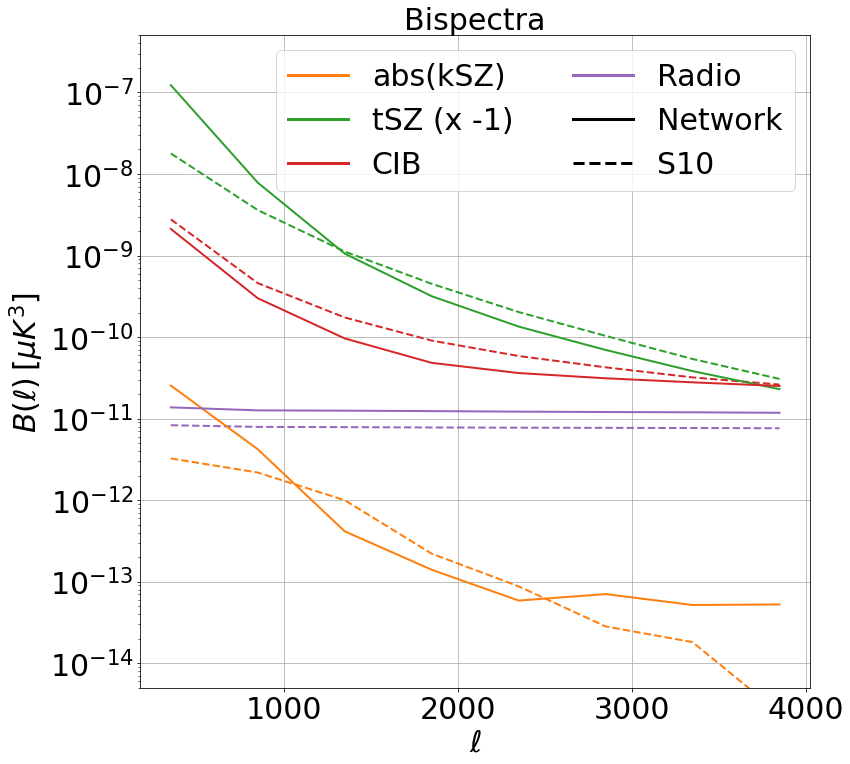

In [8]:
lbin = st_3pt.storage["lbin"][0]
lfact = lbin**2
plt.clf()
fig = plt.figure(figsize=(12,12))
ax = fig.gca()

colors = [None]*6
for i in range(6):
    colors[i] = next(ax._get_lines.prop_cycler)['color']
colors[5] = "darkblue"
vkey = "s10"
plt.plot(lbin, np.abs(st_3pt.storage["%s_ksz" %vkey][0]), lw=2, ls="--", color=colors[1])
plt.plot(lbin, -1*(st_3pt.storage["%s_tsz" %vkey][0]), lw=2, ls="--", color=colors[2])
plt.plot(lbin, (st_3pt.storage["%s_ir" %vkey][0]), lw=2, ls="--", color=colors[3])
plt.plot(lbin, (st_3pt.storage["%s_rad" %vkey][0]), lw=2, ls="--", color=colors[4])
a = st_3pt.storage["%s_rad" %vkey][0]

vkey = "mlsims"
plt.plot(lbin, np.abs(st_3pt.storage["%s_ksz" %vkey][0]), lw=2, ls="-", color=colors[1])
plt.plot(lbin, -1*(st_3pt.storage["%s_tsz" %vkey][0]), lw=2, ls="-", color=colors[2])
plt.plot(lbin, st_3pt.storage["%s_ir" %vkey][0], lw=2, ls="-", color=colors[3])
plt.plot(lbin, (st_3pt.storage["%s_rad" %vkey][0]), lw=2, ls="-", color=colors[4])

plt.plot([],[],ls="-", color=colors[1], lw=3, label="abs(kSZ)")
plt.plot([],[],ls="-", color=colors[2], lw=3, label="tSZ (x -1)")
plt.plot([],[],ls="-", color=colors[3], lw=3, label="CIB")
plt.plot([],[],ls="-", color=colors[4], lw=3, label="Radio")
#plt.plot([],[],ls="-", color=colors[5], lw=3, label="All FGs")
plt.plot([],[],ls="-", color="k", lw=3, label="Network")
plt.plot([],[],ls="--", color="k", lw=3, label="S10")
plt.plot([],[],ls="", color="k", lw=2, label="")
plt.title(r"Bispectra", fontsize=30)
#ax.set_xlabel(r"$\sqrt{(\ell^2_1+\ell^2_2+\ell^2_3)/3}$", fontsize=30)
ax.set_xlabel(r"$\ell$", fontsize=30)
#ax.set_ylabel(r"$B(\ell_1,\ell_2,\ell_3)$", fontsize=30)
ax.set_ylabel(r"$B(\ell) \: [\mu K^3]$", fontsize=30)
handles, labels = plt.gca().get_legend_handles_labels()

order = [0,1,2,3,4,5]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=30, ncol=2)
#plt.legend(fontsize=30)

ax.tick_params(axis='both', which='major', labelsize=30)
ax.tick_params(axis='both', which='minor', labelsize=30)
ax.grid()
plt.subplots_adjust(wspace=0, hspace=0)
plt.yscale("log")
#plt.xlim(0,4200)
plt.ylim(5e-15, 5e-7)
#plt.ylim(-1e-7, 1e-7)
plt.savefig(plot_path("031621_bispcetra.pdf"), bbox_inches = 'tight')


plt.show()

In [7]:
del st_3pt

In [ ]:
import pickle
overwrite = True
show_plot = True
#st_3pt = stats.STATS("030921_3ptv3_squeeze", output_dir=input_dir, overwrite=overwrite)
#st_3pt = stats.STATS("020221_3ptv9", output_dir=input_dir, overwrite=overwrite)
lmax = 2000
blmin = 10
blmax = lmax+500
flux_cut = 7
##v4 : lmax=10000, blmax=5000, flux_cut 7.
##v5 : lmax=10000, blmax=2000, flux_cut 5
##v6 : lmax=10000, blmin=100, blmax=2000, flux_cut 7. alm_filter

l = np.arange(lmax+1)

S10R = sehgal.Sehgal10ReprojectedFromCat(input_dir, SN.shape[-2:], SN.wcs)
compts = ["kappa", "ksz", "tsz", "rad","ir"]
fg_specs = S10R.get_specs(ret_dl=False, flux_cut=flux_cut, overwrite=False)

flux_cut = 7
for sim_type in ["s10", "mlsims"]:

    mode = "ksz"
    sim_idx  = 0 if sim_type == "s10" else 0
    st_idx = f"{sim_type}_{mode}"
    #if st_3pt.has_data(st_idx, sim_idx): continue
    
    print("Loading sims")
    if sim_type == "s10":
        fgmaps = np.float64(S10R.get_maps(0,0,ret_alm=False,flux_cut=flux_cut, load_processed=False))
        fgalms = curvedsky.map2alm(fgmaps, lmax=lmax, spin=0); del fgmaps 
        #fgalms = hpfgalms.copy()
    elif sim_type == "mlsims":
        fgmaps = SN.get_foreground(40, 148)
        fgalms = curvedsky.map2alm(fgmaps, lmax=lmax, spin=0); del fgmaps
        #fgalms = carfgalms.copy()
    else:
        assert(False)
    
    modes = ['ir','tsz',"rad","ksz"]#',"ksz", "rad"]#, "full", "rad", "ir"]
    #modes = ['ir','rad']
    for mode in modes:
        st_idx = f"{sim_type}_{mode}" 
        #if st_3pt.has_data(st_idx, sim_idx) : continue
        print(f"starting recon {sim_type} {mode}")
        fg_idxes = []
        assert(mode in modes)
        if mode == "cmbonly":
            fg_processed = l*0
        else:
            if mode == "ksz": 
                fg_full = fg_specs["dls_kszxksz"]
                fg_idxes=[1]
            elif mode == "tsz":
                fg_full = fg_specs["dls_tszxtsz"]
                fg_idxes=[2]
            elif mode == "ir":
                fg_full = fg_specs["dls_irxir"]
                fg_idxes=[3]
            elif mode == "rad":
                fg_full = fg_specs["dls_radxrad"]
                fg_idxes=[4]
            elif mode == "full":
                fg_full = fg_specs["dls_irxir"]+fg_specs["dls_radxrad"]+fg_specs["dls_kszxksz"]+fg_specs["dls_tszxtsz"]
                fg_idxes=[1,2,3,4]
            fg_processed = scipy.ndimage.gaussian_filter1d(fg_full, sigma=5); del fg_full

            
        fgalm = np.sum(fgalms[fg_idxes,...], axis=0)
       
        
        EST = binEstFullSky.binnedEstimator(invC=0,binSize=50,ellMin=blmin,ellMax=blmax)
        bispec, covMat, weights =EST.analyze([fgalm],Cls = [[fg_processed]],calcNorm=1);
        storage = {}
        storage['bispec'] = bispec
        storage['covMat'] = covMat
        storage['weights'] = weights
        
        with open(output_path(f"{st_idx}_3p_final_{blmin}_{blmax}.pkl"), "wb") as f:
            storage = pickle.dump(storage, f)
            

/home/dwhan89/workspace/cosmikyu/cosmikyu/sehgal.py:214: RuntimeWarning: invalid value encountered in true_divide
  specs[key] = np.nan_to_num(specs[key] / l_fact)


Loading sims
loading /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/kappa_alm_000_000_000.fits
loading /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/148_ksz_alm_000_000_000.fits
loading /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/148_tsz_alm_000_000_000.fits
loading /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/148_ir_pts_enmap_000_000_000.fits
loading /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/148_rad_pts_enmap_000_000_000.fits


[STATS] output_dir is /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues
Loading sims
starting recon s10 ir



 Order of input parameter maps matters.


/home/dwhan89/workspace/cosmikyu/cosmikyu/sehgal.py:214: RuntimeWarning: invalid value encountered in true_divide
  specs[key] = np.nan_to_num(specs[key] / l_fact)
/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: ComplexWarning: Casting complex values to real discards the imaginary part
/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part
/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in true_divide
/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:80: RuntimeWarning: invalid value encountered in multiply


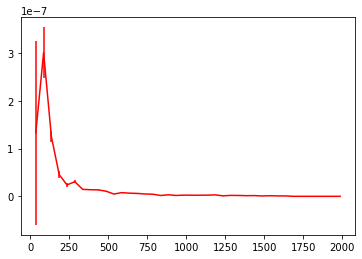

[STATS] collecting data
[STATS] saving /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/stats_030921_3ptv3_squeeze.npz from root 0
[STATS] loaded /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/stats_030921_3ptv3_squeeze.npz
starting recon s10 tsz



 Order of input parameter maps matters.


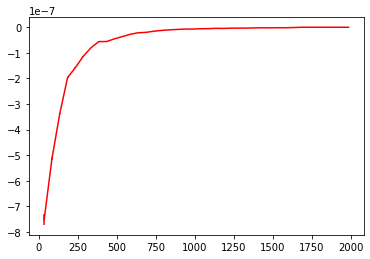

[STATS] collecting data
[STATS] saving /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/stats_030921_3ptv3_squeeze.npz from root 0
[STATS] loaded /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/stats_030921_3ptv3_squeeze.npz
starting recon s10 rad



 Order of input parameter maps matters.


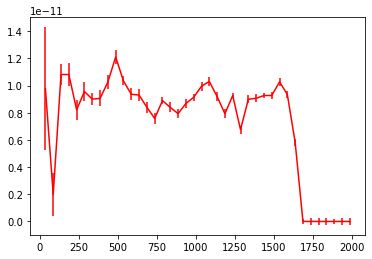

[STATS] collecting data
[STATS] saving /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/stats_030921_3ptv3_squeeze.npz from root 0
[STATS] loaded /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/stats_030921_3ptv3_squeeze.npz
starting recon s10 ksz



 Order of input parameter maps matters.


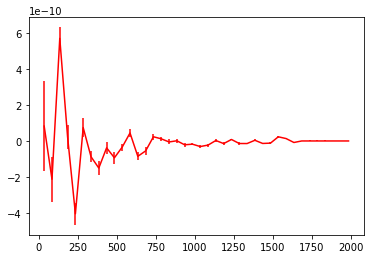

[STATS] collecting data
[STATS] saving /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/stats_030921_3ptv3_squeeze.npz from root 0
[STATS] loaded /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/stats_030921_3ptv3_squeeze.npz
Loading sims
starting recon mlsims ir



 Order of input parameter maps matters.


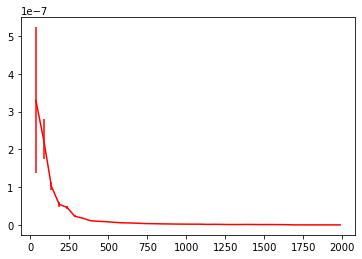

[STATS] collecting data
[STATS] saving /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/stats_030921_3ptv3_squeeze.npz from root 0
[STATS] loaded /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/stats_030921_3ptv3_squeeze.npz
starting recon mlsims tsz



 Order of input parameter maps matters.


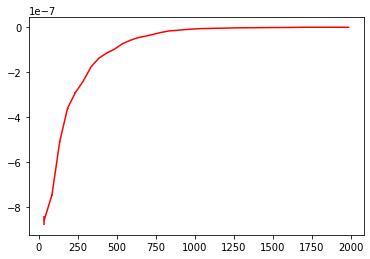

[STATS] collecting data
[STATS] saving /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/stats_030921_3ptv3_squeeze.npz from root 0
[STATS] loaded /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/stats_030921_3ptv3_squeeze.npz
starting recon mlsims rad



 Order of input parameter maps matters.


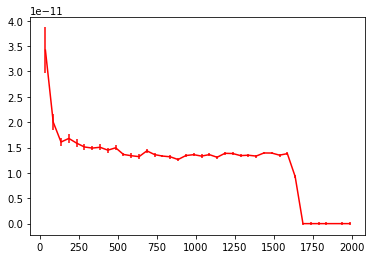

[STATS] collecting data
[STATS] saving /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/stats_030921_3ptv3_squeeze.npz from root 0
[STATS] loaded /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/stats_030921_3ptv3_squeeze.npz
starting recon mlsims ksz



 Order of input parameter maps matters.


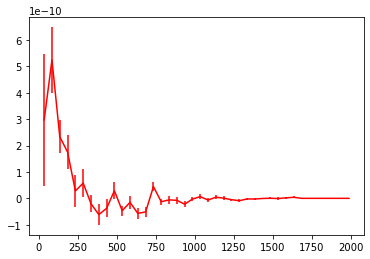

[STATS] collecting data
[STATS] saving /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/stats_030921_3ptv3_squeeze.npz from root 0
[STATS] loaded /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/stats_030921_3ptv3_squeeze.npz


In [48]:
import pickle
overwrite = True
show_plot = True
st_3pt = stats.STATS("030921_3ptv3_squeeze", output_dir=input_dir, overwrite=overwrite)
lmax = 2000
blmin = 10
blmax = lmax+500
flux_cut = 7
##v4 : lmax=10000, blmax=5000, flux_cut 7.
##v5 : lmax=10000, blmax=2000, flux_cut 5
##v6 : lmax=10000, blmin=100, blmax=2000, flux_cut 7. alm_filter

l = np.arange(lmax+1)

S10R = sehgal.Sehgal10ReprojectedFromCat(input_dir, SN.shape[-2:], SN.wcs)
compts = ["kappa", "ksz", "tsz", "rad","ir"]
fg_specs = S10R.get_specs(ret_dl=False, flux_cut=flux_cut, overwrite=False)

flux_cut = 7
for sim_type in ["s10", "mlsims"]:

    mode = "ksz"
    sim_idx  = 0 if sim_type == "s10" else 0
    st_idx = f"{sim_type}_{mode}"
    if st_3pt.has_data(st_idx, sim_idx): continue
    
    print("Loading sims")
    modes = ['ir','tsz',"rad","ksz"]#',"ksz", "rad"]#, "full", "rad", "ir"]

    for mode in modes:
        st_idx = f"{sim_type}_{mode}" 
        if st_3pt.has_data(st_idx, sim_idx) : continue
        print(f"starting recon {sim_type} {mode}")


            
        fgalm = np.sum(fgalms[fg_idxes,...], axis=0)
       
        
        EST = binEstFullSky.binnedEstimator(invC=0,binSize=50,ellMin=blmin,ellMax=blmax)
        with open(output_path(f"{st_idx}_3p_final_{blmin}_{blmax}.pkl"), "rb") as f:
        #with open(output_path(f"{st_idx}_3p_final.pkl"), "rb") as f:
            storage = pickle.load(f)
            
        bispec = storage["bispec"]
        covMat = storage["covMat"]
        weights = storage["weights"]
        del storage
        
        lbin = EST.binMidPoints
        bin_edges = np.insert(EST.binEdges, 0, 2)
        binner = mcm.PITAS_BINNER(bin_edges=bin_edges)
        
        Ls = []
        Bs = []
        Ws = []
        k = 0
        for i in range(EST.numBins):
            j = i 
            l1,l2,l3 = lbin[i],lbin[j],lbin[k]
            L = np.sqrt((l1**2+l2**2+l3**2)/3)
            Ls.append(np.float64(L))
            if np.real(covMat[0,0,0,0,0,0,i,j,k])<=0 :continue
            W = np.float64(1/covMat[0,0,0,0,0,0,i,j,k])
            Ws.append(W)
            Bs.append(np.float64(bispec[0,0,0,i,j,k]*W))
            #print(Bs)

        #print(Ls)
        _, Bbin = binner.bin(Ls, np.array(Bs), mode="sum")
        _, Wbin = binner.bin(Ls, np.array(Ws), mode="sum")

        #Bbin = np.array(Bs)
        #Wbin = np.array(Ws)
        Lbin = binner.bin_center[1:]
        #Lbin = np.array(Ls)
        
        Wbin = Wbin[1:]
        TWbin = 1/Wbin
        Bbin = Bbin[1:]*TWbin
        
        st_3pt.add_data(st_idx, sim_idx, Bbin)
        st_3pt.add_data(st_idx+"_err", sim_idx, np.sqrt(TWbin))
        st_3pt.add_data("lbin", 0, Lbin)
                
        if show_plot:
            plt.errorbar(Lbin, Bbin, np.sqrt(TWbin), color="r")
            plt.yscale("linear")
            plt.show()

        st_3pt.save_data()

<Figure size 432x288 with 0 Axes>

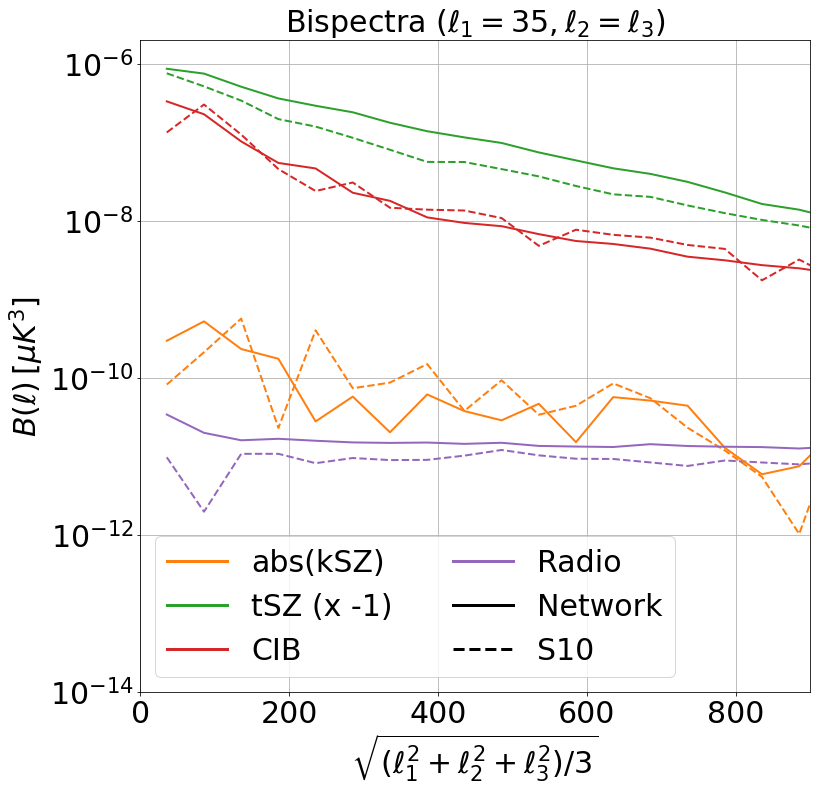

In [51]:
lbin = st_3pt.storage["lbin"][0]
lfact = lbin**2
plt.clf()
fig = plt.figure(figsize=(12,12))
ax = fig.gca()

colors = [None]*6
for i in range(6):
    colors[i] = next(ax._get_lines.prop_cycler)['color']
colors[5] = "darkblue"
vkey = "s10"
plt.plot(lbin, np.abs(st_3pt.storage["%s_ksz" %vkey][0]), lw=2, ls="--", color=colors[1])
plt.plot(lbin, -1*(st_3pt.storage["%s_tsz" %vkey][0]), lw=2, ls="--", color=colors[2])
plt.plot(lbin, (st_3pt.storage["%s_ir" %vkey][0]), lw=2, ls="--", color=colors[3])
plt.plot(lbin, (st_3pt.storage["%s_rad" %vkey][0]), lw=2, ls="--", color=colors[4])
a = st_3pt.storage["%s_rad" %vkey][0]

vkey = "mlsims"
plt.plot(lbin, np.abs(st_3pt.storage["%s_ksz" %vkey][0]), lw=2, ls="-", color=colors[1])
plt.plot(lbin, -1*(st_3pt.storage["%s_tsz" %vkey][0]), lw=2, ls="-", color=colors[2])
plt.plot(lbin, st_3pt.storage["%s_ir" %vkey][0], lw=2, ls="-", color=colors[3])
plt.plot(lbin, (st_3pt.storage["%s_rad" %vkey][0]), lw=2, ls="-", color=colors[4])

plt.plot([],[],ls="-", color=colors[1], lw=3, label="abs(kSZ)")
plt.plot([],[],ls="-", color=colors[2], lw=3, label="tSZ (x -1)")
plt.plot([],[],ls="-", color=colors[3], lw=3, label="CIB")
plt.plot([],[],ls="-", color=colors[4], lw=3, label="Radio")
#plt.plot([],[],ls="-", color=colors[5], lw=3, label="All FGs")
plt.plot([],[],ls="-", color="k", lw=3, label="Network")
plt.plot([],[],ls="--", color="k", lw=3, label="S10")
plt.plot([],[],ls="", color="k", lw=2, label="")
plt.title(r"Bispectra $(\ell_1=35, \ell_2=\ell_3)$", fontsize=30)
ax.set_xlabel(r"$\sqrt{(\ell^2_1+\ell^2_2+\ell^2_3)/3}$", fontsize=30)
#ax.set_xlabel(r"$\ell$", fontsize=30)
#ax.set_ylabel(r"$B(\ell_1,\ell_2,\ell_3)$", fontsize=30)
ax.set_ylabel(r"$B(\ell) \: [\mu K^3]$", fontsize=30)
handles, labels = plt.gca().get_legend_handles_labels()

order = [0,1,2,3,4,5]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=30, ncol=2)
#plt.legend(fontsize=30)

ax.tick_params(axis='both', which='major', labelsize=30)
ax.tick_params(axis='both', which='minor', labelsize=30)
ax.grid()
plt.subplots_adjust(wspace=0, hspace=0)
plt.yscale("log")
plt.xlim(0,900)
plt.ylim(1e-14, 2e-6)
#plt.ylim(-1e-7, 1e-7)
#plt.savefig(plot_path("031621_bispcetra.pdf"), bbox_inches = 'tight')


plt.show()

[STATS] output_dir is /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues
Loading sims
starting recon s10 ir



 Order of input parameter maps matters.


/home/dwhan89/workspace/cosmikyu/cosmikyu/sehgal.py:214: RuntimeWarning: invalid value encountered in true_divide
  specs[key] = np.nan_to_num(specs[key] / l_fact)
/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: ComplexWarning: Casting complex values to real discards the imaginary part
/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: ComplexWarning: Casting complex values to real discards the imaginary part


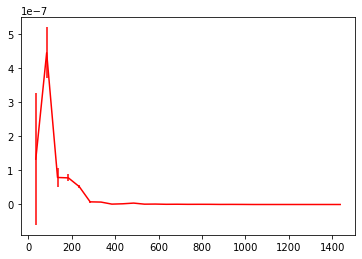

[STATS] collecting data
[STATS] saving /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/stats_030921_3ptv3_equilat.npz from root 0
[STATS] loaded /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/stats_030921_3ptv3_equilat.npz
starting recon s10 tsz



 Order of input parameter maps matters.


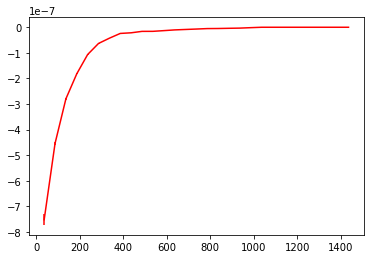

[STATS] collecting data
[STATS] saving /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/stats_030921_3ptv3_equilat.npz from root 0
[STATS] loaded /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/stats_030921_3ptv3_equilat.npz
starting recon s10 rad



 Order of input parameter maps matters.


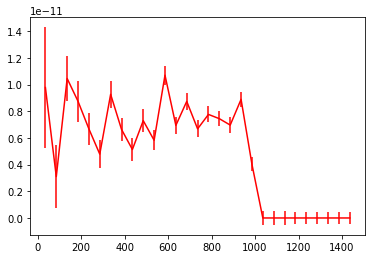

[STATS] collecting data
[STATS] saving /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/stats_030921_3ptv3_equilat.npz from root 0
[STATS] loaded /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/stats_030921_3ptv3_equilat.npz
starting recon s10 ksz



 Order of input parameter maps matters.


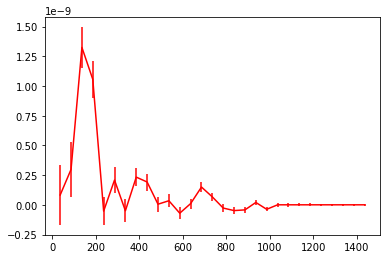

[STATS] collecting data
[STATS] saving /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/stats_030921_3ptv3_equilat.npz from root 0
[STATS] loaded /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/stats_030921_3ptv3_equilat.npz
Loading sims
starting recon mlsims ir



 Order of input parameter maps matters.


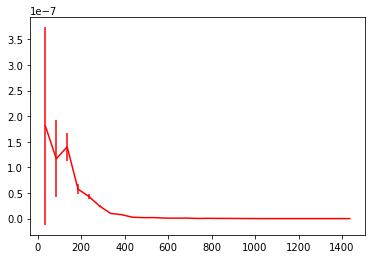

[STATS] collecting data
[STATS] saving /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/stats_030921_3ptv3_equilat.npz from root 0
[STATS] loaded /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/stats_030921_3ptv3_equilat.npz
starting recon mlsims tsz



 Order of input parameter maps matters.


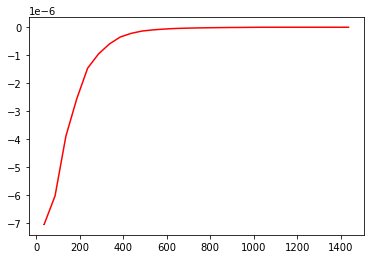

[STATS] collecting data
[STATS] saving /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/stats_030921_3ptv3_equilat.npz from root 0
[STATS] loaded /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/stats_030921_3ptv3_equilat.npz
starting recon mlsims rad



 Order of input parameter maps matters.


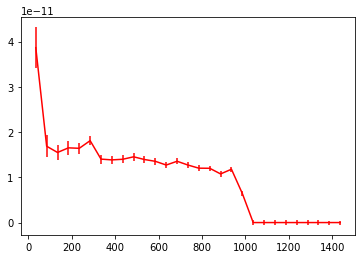

[STATS] collecting data
[STATS] saving /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/stats_030921_3ptv3_equilat.npz from root 0
[STATS] loaded /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/stats_030921_3ptv3_equilat.npz
starting recon mlsims ksz



 Order of input parameter maps matters.


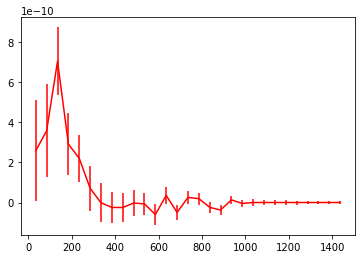

[STATS] collecting data
[STATS] saving /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/stats_030921_3ptv3_equilat.npz from root 0
[STATS] loaded /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/stats_030921_3ptv3_equilat.npz


In [54]:
import pickle
overwrite = True
show_plot = True
st_3pt = stats.STATS("030921_3ptv3_equilat", output_dir=input_dir, overwrite=overwrite)
lmax = 1000
blmin = 10
blmax = lmax+500
flux_cut = 7
##v4 : lmax=10000, blmax=5000, flux_cut 7.
##v5 : lmax=10000, blmax=2000, flux_cut 5
##v6 : lmax=10000, blmin=100, blmax=2000, flux_cut 7. alm_filter

l = np.arange(lmax+1)

S10R = sehgal.Sehgal10ReprojectedFromCat(input_dir, SN.shape[-2:], SN.wcs)
compts = ["kappa", "ksz", "tsz", "rad","ir"]
fg_specs = S10R.get_specs(ret_dl=False, flux_cut=flux_cut, overwrite=False)

flux_cut = 7
for sim_type in ["s10", "mlsims"]:

    mode = "ksz"
    sim_idx  = 0 if sim_type == "s10" else 0
    st_idx = f"{sim_type}_{mode}"
    if st_3pt.has_data(st_idx, sim_idx): continue
    
    print("Loading sims")
    modes = ['ir','tsz',"rad","ksz"]#',"ksz", "rad"]#, "full", "rad", "ir"]

    for mode in modes:
        st_idx = f"{sim_type}_{mode}" 
        if st_3pt.has_data(st_idx, sim_idx) : continue
        print(f"starting recon {sim_type} {mode}")
        
        EST = binEstFullSky.binnedEstimator(invC=0,binSize=50,ellMin=blmin,ellMax=blmax)
        with open(output_path(f"{st_idx}_3p_final_{blmin}_{blmax}.pkl"), "rb") as f:
            storage = pickle.load(f)
        bispec = storage["bispec"]
        covMat = storage["covMat"]
        weights = storage["weights"]
        del storage
        
        lbin = EST.binMidPoints
        bin_edges = np.insert(EST.binEdges, 0, 2)
        binner = mcm.PITAS_BINNER(bin_edges=bin_edges)
        
        Ls = []
        Bs = []
        Ws = []
        k = 0
        for i in range(EST.numBins):
            k = j = i 
            l1,l2,l3 = lbin[i],lbin[j],lbin[k]
            L = np.sqrt((l1**2+l2**2+l3**2)/3)
            Ls.append(np.float64(L))
            #if np.real(covMat[0,0,0,0,0,0,i,j,k])<=0 :continue
            W = np.float64(1/covMat[0,0,0,0,0,0,i,j,k])
            Ws.append(W)
            Bs.append(np.float64(bispec[0,0,0,i,j,k]*W))
            #print(Bs)

        #print(Ls)
        _, Bbin = binner.bin(Ls, np.array(Bs), mode="sum")
        _, Wbin = binner.bin(Ls, np.array(Ws), mode="sum")

        #Bbin = np.array(Bs)
        #Wbin = np.array(Ws)
        Lbin = binner.bin_center[1:]
        #Lbin = np.array(Ls)
        
        Wbin = Wbin[1:]
        TWbin = 1/Wbin
        Bbin = Bbin[1:]*TWbin
        
        st_3pt.add_data(st_idx, sim_idx, Bbin)
        st_3pt.add_data(st_idx+"_err", sim_idx, np.sqrt(TWbin))
        st_3pt.add_data("lbin", 0, Lbin)
                
        if show_plot:
            plt.errorbar(Lbin, Bbin, np.sqrt(TWbin), color="r")
            plt.yscale("linear")
            plt.show()

        st_3pt.save_data()

<Figure size 432x288 with 0 Axes>

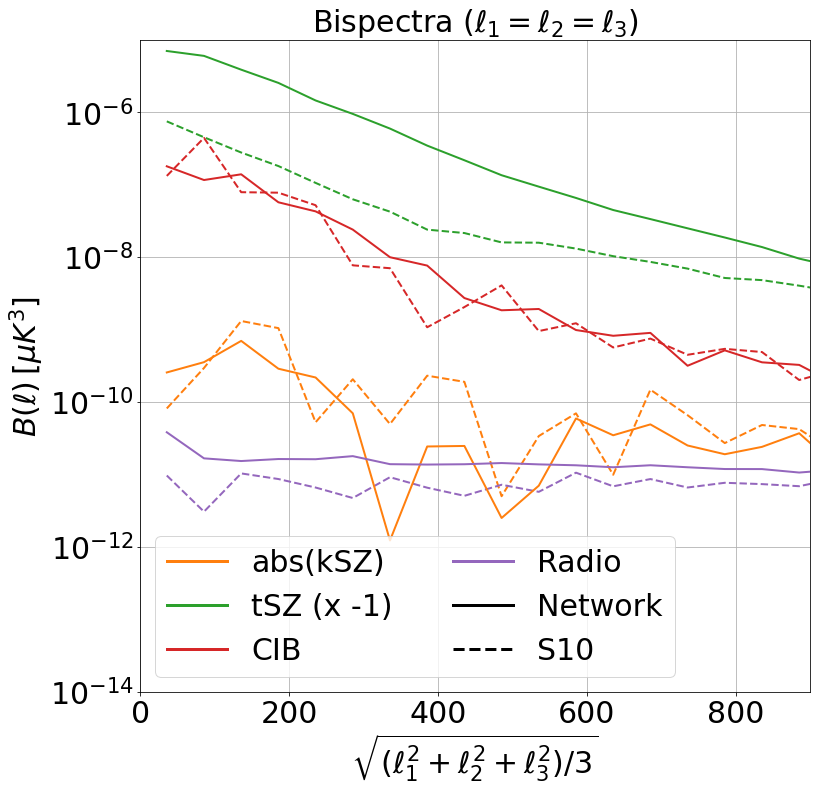

In [55]:
lbin = st_3pt.storage["lbin"][0]
lfact = lbin**2
plt.clf()
fig = plt.figure(figsize=(12,12))
ax = fig.gca()

colors = [None]*6
for i in range(6):
    colors[i] = next(ax._get_lines.prop_cycler)['color']
colors[5] = "darkblue"
vkey = "s10"
plt.plot(lbin, np.abs(st_3pt.storage["%s_ksz" %vkey][0]), lw=2, ls="--", color=colors[1])
plt.plot(lbin, -1*(st_3pt.storage["%s_tsz" %vkey][0]), lw=2, ls="--", color=colors[2])
plt.plot(lbin, (st_3pt.storage["%s_ir" %vkey][0]), lw=2, ls="--", color=colors[3])
plt.plot(lbin, (st_3pt.storage["%s_rad" %vkey][0]), lw=2, ls="--", color=colors[4])
a = st_3pt.storage["%s_rad" %vkey][0]

vkey = "mlsims"
plt.plot(lbin, np.abs(st_3pt.storage["%s_ksz" %vkey][0]), lw=2, ls="-", color=colors[1])
plt.plot(lbin, -1*(st_3pt.storage["%s_tsz" %vkey][0]), lw=2, ls="-", color=colors[2])
plt.plot(lbin, st_3pt.storage["%s_ir" %vkey][0], lw=2, ls="-", color=colors[3])
plt.plot(lbin, (st_3pt.storage["%s_rad" %vkey][0]), lw=2, ls="-", color=colors[4])

plt.plot([],[],ls="-", color=colors[1], lw=3, label="abs(kSZ)")
plt.plot([],[],ls="-", color=colors[2], lw=3, label="tSZ (x -1)")
plt.plot([],[],ls="-", color=colors[3], lw=3, label="CIB")
plt.plot([],[],ls="-", color=colors[4], lw=3, label="Radio")
#plt.plot([],[],ls="-", color=colors[5], lw=3, label="All FGs")
plt.plot([],[],ls="-", color="k", lw=3, label="Network")
plt.plot([],[],ls="--", color="k", lw=3, label="S10")
plt.plot([],[],ls="", color="k", lw=2, label="")
plt.title(r"Bispectra $(\ell_1=\ell_2=\ell_3)$", fontsize=30)
ax.set_xlabel(r"$\sqrt{(\ell^2_1+\ell^2_2+\ell^2_3)/3}$", fontsize=30)
#ax.set_xlabel(r"$\ell$", fontsize=30)
#ax.set_ylabel(r"$B(\ell_1,\ell_2,\ell_3)$", fontsize=30)
ax.set_ylabel(r"$B(\ell) \: [\mu K^3]$", fontsize=30)
handles, labels = plt.gca().get_legend_handles_labels()

order = [0,1,2,3,4,5]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=30, ncol=2)
#plt.legend(fontsize=30)

ax.tick_params(axis='both', which='major', labelsize=30)
ax.tick_params(axis='both', which='minor', labelsize=30)
ax.grid()
plt.subplots_adjust(wspace=0, hspace=0)
plt.yscale("log")
plt.xlim(0,900)
plt.ylim(1e-14, 1e-5)
#plt.ylim(-1e-7, 1e-7)
#plt.savefig(plot_path("031621_bispcetra.pdf"), bbox_inches = 'tight')


plt.show()